# Credit Card Balance EDA

rough plan: **EDA Credit_Balnce:**

verify cleaning pipelines

aggregate data 

apply cleaning / figure out how this process differs for aggregate data

apply numerical analysis func

apply categorical analysis func

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("credit_card_balance.csv")
df.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


C:\Users\david\AppData\Local\Temp\ipykernel_13196\3895461794.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data_types.values, y=data_types.index, palette="viridis")


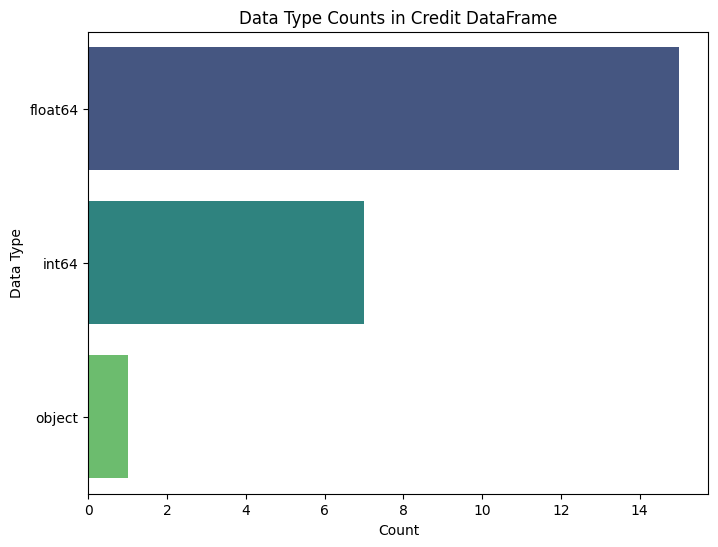

Summary of Credit DataFrame Data Types:


,Column,Data Type,Null Count,Unique Values
0,SK_ID_PREV,int64,0,104307
1,SK_ID_CURR,int64,0,103558
2,MONTHS_BALANCE,int64,0,96
3,AMT_BALANCE,float64,0,1347904
4,AMT_CREDIT_LIMIT_ACTUAL,int64,0,181
5,AMT_DRAWINGS_ATM_CURRENT,float64,749816,2267
6,AMT_DRAWINGS_CURRENT,float64,0,187005
7,AMT_DRAWINGS_OTHER_CURRENT,float64,749816,1832
8,AMT_DRAWINGS_POS_CURRENT,float64,749816,168748
9,AMT_INST_MIN_REGULARITY,float64,305236,312266


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_data_types(df, df_name="DataFrame"):
    """
    Visualizes the data types in a DataFrame.
    
    Parameters:
    - df: The DataFrame to analyze.
    - df_name: A name for the DataFrame (used in plot titles).
    """
    # Get the data types and their counts
    data_types = df.dtypes.value_counts()
    
    # Create a summary table
    summary_table = pd.DataFrame({
        'Column': df.columns,
        'Data Type': df.dtypes,
        'Null Count': df.isnull().sum(),
        
        'Unique Values': df.nunique()
    }).reset_index(drop=True)
    
    # Plot the data type counts
    plt.figure(figsize=(8, 6))
    sns.barplot(x=data_types.values, y=data_types.index, palette="viridis")
    plt.title(f"Data Type Counts in {df_name}")
    plt.xlabel("Count")
    plt.ylabel("Data Type")
    plt.show()
    
    # Display the summary table
    print(f"Summary of {df_name} Data Types:")
    display(summary_table)


visualize_data_types(df, "Credit DataFrame")

**initial observations :**

the data contains multiple rows for the same customer_id,
this is a one to many relationship, one credit applicant can have multiple rows.
Given the objective of this project is to predict default risk for individual clients, I will be aggregating the data to an applicant level and analysing these aggregated columns

In [8]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
# Custom transformer for aggregation
class AggregationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, group_key):
        self.group_key = group_key  # Define the column to group by (e.g., 'SK_ID_CURR')

    def fit(self, X, y=None):
        return self  # This transformer doesn't need to learn anything

    def transform(self, X):
        # Define the aggregation logic
        aggregated_df = X.groupby(self.group_key).agg({
            'SK_ID_PREV': 'count',  # Number of credit products per applicant
            'MONTHS_BALANCE': 'max',  # Most recent balance month
            
            # Monetary columns
            'AMT_BALANCE': ['sum', 'mean'],
            'AMT_CREDIT_LIMIT_ACTUAL': 'mean',
            'AMT_DRAWINGS_ATM_CURRENT': ['sum', 'mean'],
            'AMT_DRAWINGS_CURRENT': ['sum', 'mean'],
            'AMT_DRAWINGS_OTHER_CURRENT': ['sum', 'mean'],
            'AMT_DRAWINGS_POS_CURRENT': ['sum', 'mean'],
            'AMT_INST_MIN_REGULARITY': 'mean',
            'AMT_PAYMENT_CURRENT': ['sum', 'mean'],
            'AMT_PAYMENT_TOTAL_CURRENT': ['sum', 'mean'],
            'AMT_RECEIVABLE_PRINCIPAL': ['sum', 'mean'],
            'AMT_RECIVABLE': ['sum', 'mean'],
            'AMT_TOTAL_RECEIVABLE': ['sum', 'mean'],
            
            # Count columns
            'CNT_DRAWINGS_ATM_CURRENT': 'sum',
            'CNT_DRAWINGS_CURRENT': 'sum',
            'CNT_DRAWINGS_OTHER_CURRENT': 'sum',
            'CNT_DRAWINGS_POS_CURRENT': 'sum',
            'CNT_INSTALMENT_MATURE_CUM': 'sum',
            
            # Contract status
            'NAME_CONTRACT_STATUS': lambda x: x.mode()[0],  # Most frequent contract status
            
            # DPD (Days Past Due)
            'SK_DPD': 'max',
            'SK_DPD_DEF': 'max'
        }).reset_index()

        # Flatten the column names if needed
        aggregated_df.columns = [col[0] if col[0] == self.group_key else '_'.join(col).strip() for col in aggregated_df.columns]


        return aggregated_df
    


# Create the sklearn pipeline
aggregation_pipeline = Pipeline([
    ('aggregator', AggregationTransformer(group_key='SK_ID_CURR'))
])


aggregated_df = aggregation_pipeline.fit_transform(df)
aggregated_df.head()


,SK_ID_CURR,SK_ID_PREV_count,MONTHS_BALANCE_max,AMT_BALANCE_sum,AMT_BALANCE_mean,AMT_CREDIT_LIMIT_ACTUAL_mean,AMT_DRAWINGS_ATM_CURRENT_sum,AMT_DRAWINGS_ATM_CURRENT_mean,AMT_DRAWINGS_CURRENT_sum,AMT_DRAWINGS_CURRENT_mean,...,AMT_TOTAL_RECEIVABLE_sum,AMT_TOTAL_RECEIVABLE_mean,CNT_DRAWINGS_ATM_CURRENT_sum,CNT_DRAWINGS_CURRENT_sum,CNT_DRAWINGS_OTHER_CURRENT_sum,CNT_DRAWINGS_POS_CURRENT_sum,CNT_INSTALMENT_MATURE_CUM_sum,NAME_CONTRACT_STATUS_<lambda>,SK_DPD_max,SK_DPD_DEF_max
0,100006,6,-1,0.000,0.000000,270000.000000,0.0,NaN,0.0,0.000000,...,0.000,0.000000,0.0,0,0.0,0.0,0.0,Active,0,0
1,100011,74,-2,4031676.225,54482.111149,164189.189189,180000.0,2432.432432,180000.0,2432.432432,...,4028055.255,54433.179122,4.0,4,0.0,0.0,1881.0,Active,0,0
2,100013,96,-1,1743352.245,18159.919219,131718.750000,571500.0,6350.000000,571500.0,5953.125000,...,1737703.665,18101.079844,23.0,23,0.0,0.0,1666.0,Active,1,1
3,100021,17,-2,0.000,0.000000,675000.000000,0.0,NaN,0.0,0.000000,...,0.000,0.000000,0.0,0,0.0,0.0,0.0,Completed,0,0
4,100023,8,-4,0.000,0.000000,135000.000000,0.0,NaN,0.0,0.000000,...,0.000,0.000000,0.0,0,0.0,0.0,0.0,Active,0,0


### Aggregation Explanation:

---

- **`SK_ID_PREV`**: Counts the number of credit products (loans, credit cards, etc.) associated with each applicant (`SK_ID_CURR`).

- **`MONTHS_BALANCE`**: Takes the maximum value to capture the most recent balance month across all credit products for each applicant.

---

### Monetary Columns:

- **`AMT_BALANCE`**: Aggregated with both `sum` (total balance across all products) and `mean` (average balance per product).

- **`AMT_CREDIT_LIMIT_ACTUAL`**: Uses `mean` to calculate the average credit limit across all products.

- **`AMT_DRAWINGS_*` (ATM, POS, OTHER, CURRENT)**: Aggregated with `sum` (total drawings) and `mean` (average drawing per product) to capture both the total and typical behavior across products.

- **`AMT_INST_MIN_REGULARITY`**: Uses `mean` to find the average minimum regular installment across products.

- **`AMT_PAYMENT_CURRENT`** & **`AMT_PAYMENT_TOTAL_CURRENT`**: Aggregated with both `sum` (total payments made) and `mean` (average payments per product).

- **`AMT_RECEIVABLE_PRINCIPAL`**, **`AMT_RECIVABLE`**, **`AMT_TOTAL_RECEIVABLE`**: Aggregated with `sum` (total receivable amount) and `mean` (average receivable amount per product).

---

### Count Columns:

- **`CNT_DRAWINGS_*` (ATM, POS, OTHER, CURRENT)**: Uses `sum` to aggregate the total number of drawings in each category for the applicant.

- **`CNT_INSTALMENT_MATURE_CUM`**: Sums the total number of matured installments across products.

---

- **`NAME_CONTRACT_STATUS`**: Uses `mode` to select the most frequent contract status for each applicant.

---

### DPD Columns:

- **`SK_DPD`** & **`SK_DPD_DEF`**: Uses `max` to capture the worst delay (days past due) experienced across all products for each applicant.


In [9]:
# reused code from other eda

#generic imports I will 100% be using
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Creating a group of functions to analyse the missing data
def missing_data_summary(df):
    """
    Returns a summary of missing data in each column.
    """
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    return pd.DataFrame({'Missing Values': missing_data, 'Percent Missing': missing_percent}).sort_values(by='Percent Missing', ascending=False)


def plot_missing_data(df):
    """
    Visualizes the missing data using a heatmap.
    """
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title('Heatmap of Missing Data')
    plt.show()

def plot_missing_bar(df, threshold=0):
    """
    Plots the percentage of missing data for each column, with improved readability.
    Only columns with more than `threshold` percent missing data will be plotted.
    """
    missing_percent = df.isnull().mean() * 100
    missing_percent = missing_percent[missing_percent > threshold].sort_values()
    
    plt.figure(figsize=(12, 8))  # Adjust the figure size for better readability
    missing_percent.plot(kind='barh', color='c')  # Horizontal bar plot for more space on x-axis
    plt.title('Percentage of Missing Data')
    plt.xlabel('% Missing')
    plt.xticks(rotation=0)  # Keep the percentage labels horizontal
    plt.ylabel('Columns')
    plt.show()


def missingness_correlation(df):
    """
    Returns a dataframe of correlations between missing data indicators and other variables. (useful for MAR data)
    """
    missing_indicators = df.isnull().astype(int)
    correlations = missing_indicators.corrwith(df.select_dtypes(include=[float, int]), axis=0)
    return correlations.sort_values(ascending=False)

def compare_missing_vs_nonmissing(df, col_missing, col_compare):
    """
    Compares the distribution of another variable for missing vs non-missing values in the given column. (useful for mar)
    """
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[col_missing].isnull(), y=df[col_compare])
    plt.title(f'Comparison of {col_compare} for Missing vs Non-Missing {col_missing}')
    plt.show()

def check_nmar(df, col_missing, col_categorical):
    """
    Checks whether the missingness in `col_missing` is related to values in a categorical variable `col_categorical`.
    """
    missing_indicator = df[col_missing].isnull().astype(int)
    grouped_missing = df.groupby(col_categorical)[missing_indicator.name].mean()
    print(grouped_missing)
    
    plt.figure(figsize=(10, 6))
    grouped_missing.plot(kind='bar', color='orange')
    plt.title(f'Missingness in {col_missing} across {col_categorical}')
    plt.ylabel('Proportion Missing')
    plt.show()




#for better interpretabiltiy of outputs
pd.set_option('display.max_rows', None)  # Ensure all rows are displayed
pd.set_option('display.max_columns', None)  # Ensure all columns are displayed



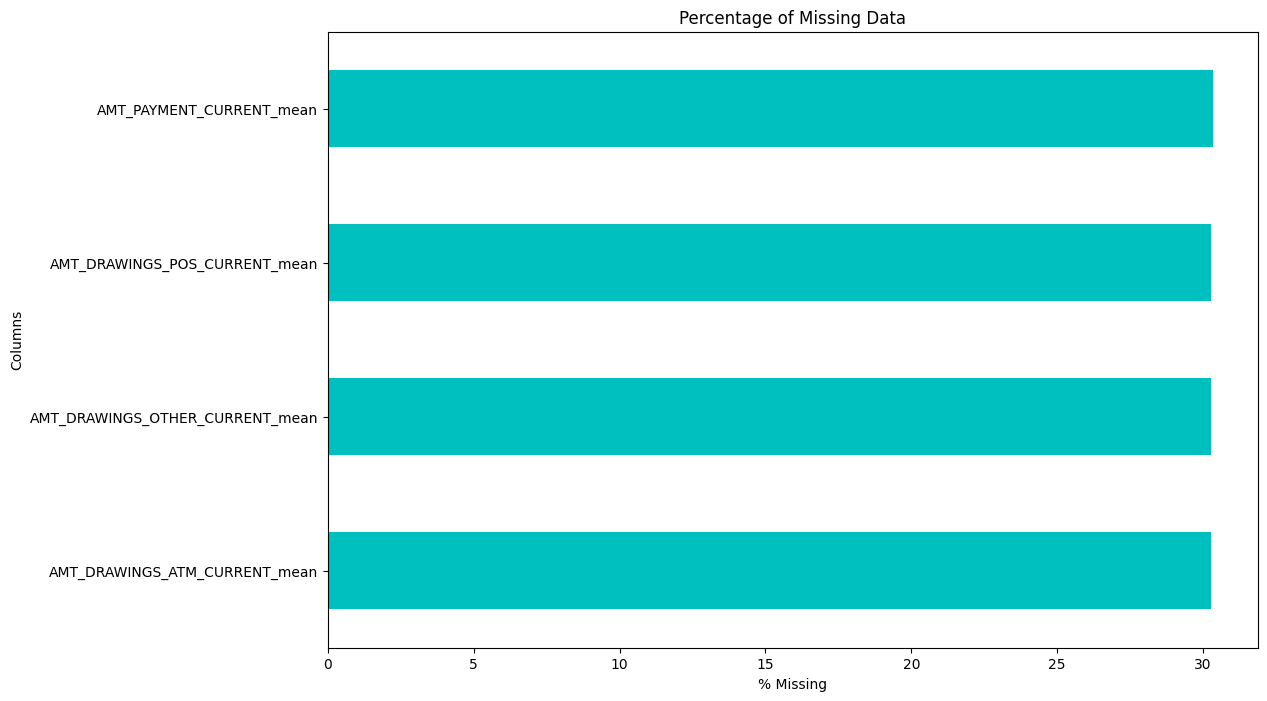

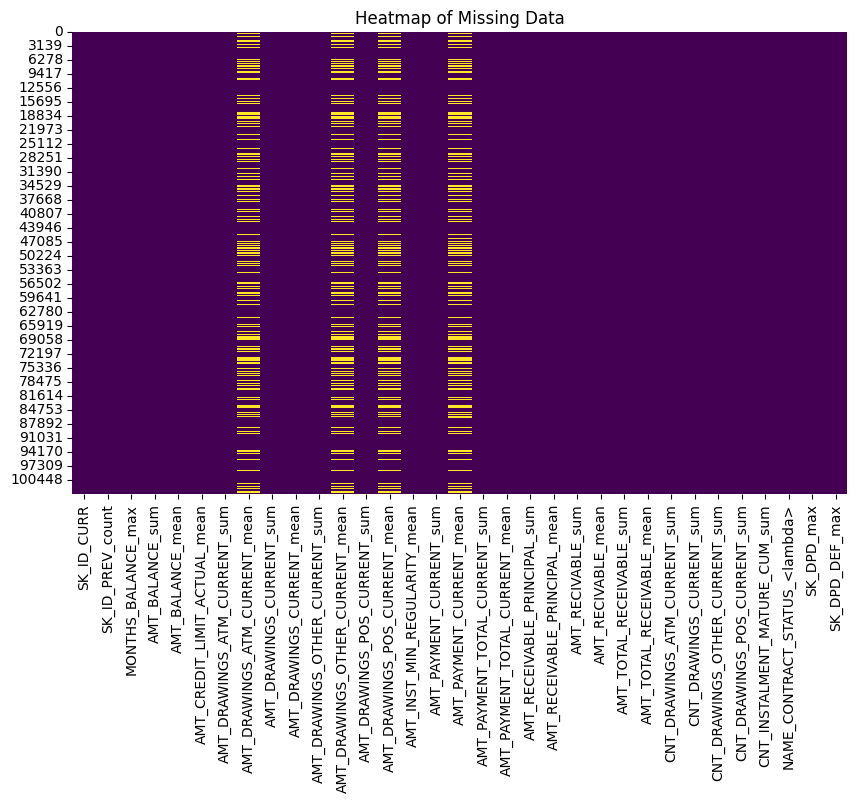

In [10]:
missing_data_summary(aggregated_df)
plot_missing_bar(aggregated_df)
plot_missing_data(aggregated_df)

# Analyzing Missingness

---

### Likelihood of NMAR (Not Missing At Random)

The missing values in columns like `AMT_PAYMENT_CURRENT_mean`, `AMT_DRAWINGS_POS_CURRENT_mean`, and others are likely **Not Missing At Random (NMAR)** due to:

1. **Behavior-Driven Missingness**:
   - Missing values are often driven by applicant actions (e.g., no payments, no withdrawals), indicating **financial distress** or intentional non-use.

2. **Non-Usage as a Financial Indicator**:
   - No recent payments or transactions (e.g., ATM, POS) may suggest **inability to pay**, **maxed-out limits**, or a decision to avoid further debt accumulation.

3. **Insightful Missingness**:
   - Missingness itself could signal higher default risk, as it reflects **strategic** or **circumstantial financial behavior** rather than random data absence.

---

### Conclusion:
This data is likely **NMAR** because the missingness is directly tied to applicant financial behavior, providing crucial insights into default probability.

---

### How to Handle this Missingness:
To address this missingness, I will apply a similar approach used in the `application_train` dataset. Specifically, I will:
1. **Create flag columns** for rows with missing data.
2. **Impute with median values**, ensuring that the dataset is not distorted when scaling. Median imputation is preferred to preserve the integrity of the data while maintaining predictive power.


In [11]:
### Here I'll be creating a generic parts of a pipeline clean the data:

# What Happens in the Pipeline:
# Step 1: Flag missing values in NMAR assumed numericals
# Step 2: Impute assumed NMAR categoricals 'Unknown'
# Step 3: Cap outliers in the data so scaling isn't distorted significantly by massive outliers such as billionaire loan applications
# Step 4: Handle any remaining missing values in numeric columns using the mean.
# Step 5: Handle any remaining missing values in categorical columns using the mode.


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

# FlagMissing transformer 
class CFlagMissing(BaseEstimator, TransformerMixin):
    """
    Flags missing values by creating new columns for each feature indicating if a value is missing.
    This helps track where data was missing for future analysis.
    """
    def __init__(self, columns_to_flag):
        self.columns_to_flag = columns_to_flag
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()  # Avoid modifying original data during transformation
        
        # Create a separate DataFrame for the flags
        missing_flags = pd.DataFrame()
        
        for col in self.columns_to_flag:
            missing_flags[f'FLAG_{col}'] = np.where(X[col].isnull(), 0, 1)
        
        # Concatenate the flags to the original DataFrame (this is done to avoid fragmentation)
        X = pd.concat([X, missing_flags], axis=1)
        
        return X

# Custom transformer to impute missing values with specified strategies
class CImputeColumns(BaseEstimator, TransformerMixin):
    """
    Imputes missing values using different strategies:
    - Median for selected columns.
    - 'Unknown' for selected categorical columns.
    - Zero for other selected columns.
    """
    def __init__(self, unknown_columns=None):
        self.unknown_columns = unknown_columns
  
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        # Impute with 'Unknown' for specified categorical columns
        if self.unknown_columns:
            for col in self.unknown_columns:
                X[col].fillna('Unknown', inplace=True)
        
        return X

# Custom transformer to cap outliers before scaling, ensuring percentiles are only calculated once
class CCapOutliers(BaseEstimator, TransformerMixin):
    """
    Caps outliers for numerical columns by setting values above the specified percentiles.
    The percentiles are calculated once during the fit and applied consistently during transforms.
    """
    def __init__(self, columns_to_cap, lower_percentile=2, upper_percentile=98):
        self.columns_to_cap = columns_to_cap
        self.lower_percentile = lower_percentile
        self.upper_percentile = upper_percentile
        self.lower_caps_ = {}
        self.upper_caps_ = {}
    
    def fit(self, X, y=None):
        # Calculate and store the caps for each column during fit
        for col in self.columns_to_cap:
            self.lower_caps_[col] = X[col].quantile(self.lower_percentile / 100)
            self.upper_caps_[col] = X[col].quantile(self.upper_percentile / 100)
        return self
    
    def transform(self, X):
        X = X.copy()  # Work on a copy to avoid modifying the original dataframe
        # Apply the pre-calculated caps during transform
        for col in self.columns_to_cap:
            X[col] = X[col].clip(lower=self.lower_caps_[col], upper=self.upper_caps_[col])
        return X

# Custom transformer to scale numerical columns
class CScaleNumericFeatures(BaseEstimator, TransformerMixin):
    """
    Scales numerical features using StandardScaler.
    This ensures that all features are on a similar scale, which helps models converge faster.
    """
    def __init__(self, columns_to_scale):
        self.columns_to_scale = columns_to_scale
        self.scaler = StandardScaler()
    
    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns_to_scale])
        return self
    
    def transform(self, X):
        X = X.copy()
        X[self.columns_to_scale] = self.scaler.transform(X[self.columns_to_scale])
        return X

# Custom transformer to impute remaining missing values with mean for numeric columns
class CImputeWithMedian(BaseEstimator, TransformerMixin):
    """
    Imputes missing values for numeric columns using the mean of each column.
    This is useful for handling the last few missing values in numeric columns.
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        for col in X.select_dtypes(include=['float64', 'int64']).columns:
            if X[col].isnull().sum() > 0:
                X[col].fillna(X[col].median(), inplace=True)
        return X

# Custom transformer to impute remaining missing values with mode for non-numeric columns
class CImputeWithMode(BaseEstimator, TransformerMixin):
    """
    Imputes missing values for non-numeric columns using the most frequent value (mode).
    This is useful for categorical data.
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        for col in X.select_dtypes(exclude=['float64', 'int64']).columns:
            if X[col].isnull().sum() > 0:
                X[col].fillna(X[col].mode()[0], inplace=True)
        return X



In [12]:
credit_flag_cols= [
    'AMT_PAYMENT_CURRENT_mean',
    'AMT_DRAWINGS_POS_CURRENT_mean',
    'AMT_DRAWINGS_OTHER_CURRENT_mean',
    'AMT_DRAWINGS_ATM_CURRENT_mean'
]
credit_numeric_cols = ['SK_ID_CURR', 'SK_ID_PREV_count', 'MONTHS_BALANCE_max', 'AMT_BALANCE_sum', 'AMT_BALANCE_mean', 'AMT_CREDIT_LIMIT_ACTUAL_mean', 'AMT_DRAWINGS_ATM_CURRENT_sum', 'AMT_DRAWINGS_ATM_CURRENT_mean', 'AMT_DRAWINGS_CURRENT_sum', 'AMT_DRAWINGS_CURRENT_mean', 'AMT_DRAWINGS_OTHER_CURRENT_sum', 'AMT_DRAWINGS_OTHER_CURRENT_mean', 'AMT_DRAWINGS_POS_CURRENT_sum', 'AMT_DRAWINGS_POS_CURRENT_mean', 'AMT_INST_MIN_REGULARITY_mean', 'AMT_PAYMENT_CURRENT_sum', 'AMT_PAYMENT_CURRENT_mean', 'AMT_PAYMENT_TOTAL_CURRENT_sum', 'AMT_PAYMENT_TOTAL_CURRENT_mean', 'AMT_RECEIVABLE_PRINCIPAL_sum', 'AMT_RECEIVABLE_PRINCIPAL_mean', 'AMT_RECIVABLE_sum', 'AMT_RECIVABLE_mean', 'AMT_TOTAL_RECEIVABLE_sum', 'AMT_TOTAL_RECEIVABLE_mean', 'CNT_DRAWINGS_ATM_CURRENT_sum', 'CNT_DRAWINGS_CURRENT_sum', 'CNT_DRAWINGS_OTHER_CURRENT_sum', 'CNT_DRAWINGS_POS_CURRENT_sum', 'CNT_INSTALMENT_MATURE_CUM_sum', 'SK_DPD_max', 'SK_DPD_DEF_max']
# Create the pipeline that chains all the transformations together
credit_pipeline = Pipeline(steps=[
    ('flag_missing', CFlagMissing(columns_to_flag=credit_flag_cols)),
    ('cap_outliers', CCapOutliers(columns_to_cap=credit_numeric_cols)),  # Cap outliers
    ('mean_impute', CImputeWithMedian()),   # Impute remaining numeric columns with median
    ('mode_impute', CImputeWithMode())    # Impute remaining non-numeric columns with mode
])


#fit the pipeline
credit_pipeline.fit(aggregated_df)
#transform df
clean_aggregated_df = credit_pipeline.transform(aggregated_df)
#checking for missingvalues
clean_aggregated_df.isnull().sum()

C:\Users\david\AppData\Local\Temp\ipykernel_13196\2720404512.py:126: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].median(), inplace=True)
C:\Users\david\AppData\Local\Temp\ipykernel_13196\2720404512.py:126: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

SK_ID_CURR                              0
SK_ID_PREV_count                        0
MONTHS_BALANCE_max                      0
AMT_BALANCE_sum                         0
AMT_BALANCE_mean                        0
AMT_CREDIT_LIMIT_ACTUAL_mean            0
AMT_DRAWINGS_ATM_CURRENT_sum            0
AMT_DRAWINGS_ATM_CURRENT_mean           0
AMT_DRAWINGS_CURRENT_sum                0
AMT_DRAWINGS_CURRENT_mean               0
AMT_DRAWINGS_OTHER_CURRENT_sum          0
AMT_DRAWINGS_OTHER_CURRENT_mean         0
AMT_DRAWINGS_POS_CURRENT_sum            0
AMT_DRAWINGS_POS_CURRENT_mean           0
AMT_INST_MIN_REGULARITY_mean            0
AMT_PAYMENT_CURRENT_sum                 0
AMT_PAYMENT_CURRENT_mean                0
AMT_PAYMENT_TOTAL_CURRENT_sum           0
AMT_PAYMENT_TOTAL_CURRENT_mean          0
AMT_RECEIVABLE_PRINCIPAL_sum            0
AMT_RECEIVABLE_PRINCIPAL_mean           0
AMT_RECIVABLE_sum                       0
AMT_RECIVABLE_mean                      0
AMT_TOTAL_RECEIVABLE_sum          

In [13]:
#merging target from Application_Train to see relationships in the data
application_df = pd.read_csv("application_train_train.csv")

# Renaming 'SK_ID_CURR_' to 'SK_ID_CURR' in df2 for the merge
clean_aggregated_df = clean_aggregated_df.rename(columns={'SK_ID_CURR_': 'SK_ID_CURR'})


print(application_df.columns)
print(clean_aggregated_df.columns)

merged_df = application_df[['SK_ID_CURR', 'TARGET']].merge(clean_aggregated_df, on='SK_ID_CURR', how='inner')
merged_df.head()

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)
Index(['SK_ID_CURR', 'SK_ID_PREV_count', 'MONTHS_BALANCE_max',
       'AMT_BALANCE_sum', 'AMT_BALANCE_mean', 'AMT_CREDIT_LIMIT_ACTUAL_mean',
       'AMT_DRAWINGS_ATM_CURRENT_sum', 'AMT_DRAWINGS_ATM_CURRENT_mean',
       'AMT_DRAWINGS_CURRENT_sum', 'AMT_DRAWINGS_CURRENT_mean',
       'AMT_DRAWINGS_OTHER_CURRENT_sum', 'AMT_DRAWINGS_OTHER_CURRENT_mean',
       'AMT_DRAWINGS_POS_CURRENT_sum', 'AMT_DRAWINGS_POS_CURRENT_mean',
       'AMT_INST_MIN_REGULARITY_mean', 'AMT_PAYMENT_CUR

C:\Users\david\AppData\Local\Temp\ipykernel_13196\1718377887.py:11: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  merged_df = application_df[['SK_ID_CURR', 'TARGET']].merge(clean_aggregated_df, on='SK_ID_CURR', how='inner')


,SK_ID_CURR,TARGET,SK_ID_PREV_count,MONTHS_BALANCE_max,AMT_BALANCE_sum,AMT_BALANCE_mean,AMT_CREDIT_LIMIT_ACTUAL_mean,AMT_DRAWINGS_ATM_CURRENT_sum,AMT_DRAWINGS_ATM_CURRENT_mean,AMT_DRAWINGS_CURRENT_sum,AMT_DRAWINGS_CURRENT_mean,AMT_DRAWINGS_OTHER_CURRENT_sum,AMT_DRAWINGS_OTHER_CURRENT_mean,AMT_DRAWINGS_POS_CURRENT_sum,AMT_DRAWINGS_POS_CURRENT_mean,AMT_INST_MIN_REGULARITY_mean,AMT_PAYMENT_CURRENT_sum,AMT_PAYMENT_CURRENT_mean,AMT_PAYMENT_TOTAL_CURRENT_sum,AMT_PAYMENT_TOTAL_CURRENT_mean,AMT_RECEIVABLE_PRINCIPAL_sum,AMT_RECEIVABLE_PRINCIPAL_mean,AMT_RECIVABLE_sum,AMT_RECIVABLE_mean,AMT_TOTAL_RECEIVABLE_sum,AMT_TOTAL_RECEIVABLE_mean,CNT_DRAWINGS_ATM_CURRENT_sum,CNT_DRAWINGS_CURRENT_sum,CNT_DRAWINGS_OTHER_CURRENT_sum,CNT_DRAWINGS_POS_CURRENT_sum,CNT_INSTALMENT_MATURE_CUM_sum,NAME_CONTRACT_STATUS_<lambda>,SK_DPD_max,SK_DPD_DEF_max,FLAG_AMT_PAYMENT_CURRENT_mean,FLAG_AMT_DRAWINGS_POS_CURRENT_mean,FLAG_AMT_DRAWINGS_OTHER_CURRENT_mean,FLAG_AMT_DRAWINGS_ATM_CURRENT_mean
0,191894,0,11,-2,0.000,0.000000,765000.0,0.0,4500.000000,0.000,0.000000,0.0,0.0,0.0000,365.790547,0.000000,0.000,9856.811065,0.000,0.000000,0.00,0.000000,0.000,0.000000,0.000,0.000000,0.0,0,0.0,0.0,0.0,Active,0,0,0,0,0,0
1,185763,0,22,-2,7180514.730,326387.033182,540000.0,15750.0,715.909091,1229971.545,55907.797500,0.0,0.0,788116.1562,55191.888409,17247.003158,950227.155,47511.357750,901567.620,40980.346364,6931267.38,315057.608182,7168108.725,325823.123864,7168108.725,325823.123864,2.0,176,0.0,161.0,171.0,Active,0,0,1,1,1,1
2,428649,0,95,-2,1467253.710,15444.775895,67500.0,22500.0,236.842105,22500.000,236.842105,0.0,0.0,0.0000,0.000000,1138.917316,144500.355,1521.056368,143347.815,1508.924368,1413222.84,14876.029895,1466874.045,15440.779421,1466874.045,15440.779421,1.0,1,0.0,0.0,2920.0,Active,0,0,1,1,1,1
3,345767,0,22,-1,0.000,0.000000,45000.0,0.0,4500.000000,0.000,0.000000,0.0,0.0,0.0000,365.790547,0.000000,0.000,9856.811065,0.000,0.000000,0.00,0.000000,0.000,0.000000,0.000,0.000000,0.0,0,0.0,0.0,0.0,Active,0,0,0,0,0,0
4,352896,0,31,-1,5888205.225,189942.104032,225000.0,455850.0,14704.838710,467747.280,15088.621935,0.0,0.0,11897.2800,383.783226,9352.813500,531000.000,17700.000000,531000.000,17129.032258,5619112.92,181261.707097,5873404.725,189464.668548,5873404.725,189464.668548,11.0,14,0.0,3.0,465.0,Active,0,0,1,1,1,1


In [10]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import jarque_bera, skew, kurtosis, ttest_ind



def segment_analysis(df, feature, target='TARGET', bins=4, ax=None):
    # Remove rows with missing values for the given feature
    df_clean = df.dropna(subset=[feature])
    
    # Define custom labels based on the number of bins
    bin_labels = {
        4: ['0-25%', '25-50%', '50-75%', '75-100%'],
        5: ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%'],
        # Add more options for different bin counts if needed
    }
    
    # Create quantile bins for the feature
    df_clean['income_bin'] = pd.qcut(df_clean[feature], bins, labels=bin_labels.get(bins, [f'Q{i}' for i in range(1, bins+1)]))
    
    # Group by income_bin and calculate default rates (mean of target) and count per bin
    income_groups = df_clean.groupby('income_bin').agg({
        target: ['mean', 'count']  # Default rate and count per bin
    }).reset_index()

    # Rename columns for better readability
    income_groups.columns = ['income_bin', 'default_rate', 'count']
    
    # Plot the default rate across income segments (quantiles) in the provided axis
    sns.barplot(x='income_bin', y='default_rate', data=income_groups, ax=ax)
    ax.set_title(f'Default Rate Across {feature} Segments (Quantiles)')
    ax.set_ylabel('Default Rate')
    ax.set_xlabel(f'{feature} Segments (Percentiles)')
    
    return income_groups

# Function to plot histogram and boxplot with percentile filtering
def plot_histogram_and_boxplot(df, column_name, percentile=100):
    if column_name in df.columns and pd.api.types.is_numeric_dtype(df[column_name]):
        # Filter out extreme values above a given percentile
        threshold = np.percentile(df[column_name], percentile)
        filtered_data = df[df[column_name] <= threshold]
        
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
        
        # Histogram
        axes[0].hist(filtered_data[column_name], bins=30, edgecolor='k', alpha=0.7)
        axes[0].set_title(f'Histogram of {column_name} (<= {percentile}th Percentile)')
        axes[0].set_xlabel(column_name)
        axes[0].set_ylabel('Frequency')
        axes[0].grid(True)
        
        # Boxplot with outliers still shown
        axes[1].boxplot(filtered_data[column_name], vert=False, showfliers=True)
        axes[1].set_title(f'Boxplot of {column_name} (With Outliers)')
        axes[1].set_xlabel(column_name)
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"{column_name} is either not a column in the dataframe or not numeric.")

# Function to assess normality using Jarque-Bera test, skewness, and kurtosis
def assess_normality(df, column_name, percentile=100):
    if column_name in df.columns and pd.api.types.is_numeric_dtype(df[column_name]):
        # Filter the data to exclude values above a given percentile
        threshold = np.percentile(df[column_name], percentile)
        filtered_data = df[df[column_name] <= threshold][column_name].dropna()
        
        # Jarque-Bera test
        jb_stat, jb_pvalue = jarque_bera(filtered_data)
        
        # Descriptive statistics
        skewness = skew(filtered_data)
        kurt_value = kurtosis(filtered_data, fisher=False)
        
        # Display results
        print(f"Normality Assessment for {column_name} (<= {percentile}th Percentile):")
        print(f"Jarque-Bera Statistic: {jb_stat:.4f}, p-value: {jb_pvalue:.4f}")
        print(f"Skewness: {skewness:.4f}")
        print(f"Kurtosis: {kurt_value:.4f}")
        
        if jb_pvalue < 0.05:
            print("Conclusion: The data is likely not normally distributed (reject null hypothesis). \n")
        else:
            print("Conclusion: The data appears to be normally distributed (fail to reject null hypothesis). \n")
    else:
        print(f"{column_name} is either not a column in the dataframe or not numeric.")

def bivariate_analysis(df, numerical_feature, target, percentile=100, ax=None):
    if numerical_feature in df.columns and pd.api.types.is_numeric_dtype(df[numerical_feature]):
        # Filter the data to exclude values above a given percentile
        threshold = np.percentile(df[numerical_feature], percentile)
        filtered_df = df[df[numerical_feature] <= threshold]
        
        # Convert target column values to integer strings to match the palette keys
        filtered_df[target] = filtered_df[target].astype(int).astype(str)
        
        # Custom color palette: green for non-defaulters ('0'), red for defaulters ('1')
        palette = {'0': 'green', '1': 'red'}
        
        # Boxplot to visualize the relationship with custom colors
        sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)
        ax.set_title(f"Bivariate Analysis of {numerical_feature} vs Defaulter/Non-Defaulter")
        
        # Group means
        group_0 = filtered_df[filtered_df[target] == '0'][numerical_feature]
        group_1 = filtered_df[filtered_df[target] == '1'][numerical_feature]
        
        # Perform t-test
        t_stat, p_value = ttest_ind(group_0, group_1, nan_policy='omit')
        
        print(f"Percentile limit: {percentile}th")
        print(f"Mean for target=0 (Non-Defaulter): {group_0.mean()}")
        print(f"Mean for target=1 (Defaulter): {group_1.mean()}")
        print(f"t-statistic: {t_stat}, p-value: {p_value}")
        
        if p_value < 0.05:
            print("There is a significant difference between the groups. \n")
        else:
            print("No significant difference between the groups. \n")
    else:
        print(f"{numerical_feature} is either not a column in the dataframe or not numeric.")






# Bivariate analysis with custom colors and subplotting
def bivariate_analysis2(df, numerical_feature, target, percentile=100, ax=None):
    if numerical_feature in df.columns and pd.api.types.is_numeric_dtype(df[numerical_feature]):
        # Filter the data to exclude values above a given percentile
        threshold = np.percentile(df[numerical_feature], percentile)
        filtered_df = df[df[numerical_feature] <= threshold]
        
        # Ensure target column is of type string to match palette keys
        filtered_df[target] = filtered_df[target].astype(str)
        
        # Custom color palette: green for non-defaulters (target='0'), red for defaulters (target='1')
        palette = {'0': 'green', '1': 'red'}
        
        # If ax is None, create a new figure and axis
        if ax is None:
            fig, ax = plt.subplots()

        # Boxplot to visualize the relationship with custom colors
        sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)
        ax.set_title(f"Bivariate Analysis of {numerical_feature} vs Defaulter/Non-Defaulter")
        
        # Group means
        group_0 = filtered_df[filtered_df[target] == '0'][numerical_feature]
        group_1 = filtered_df[filtered_df[target] == '1'][numerical_feature]
        
        # t-test to check if means are significantly different
        t_stat, p_value = ttest_ind(group_0, group_1, nan_policy='omit')
        
        print(f"Percentile limit: {percentile}th")
        print(f"Mean for target=0 (Non-Defaulter): {group_0.mean()}")
        print(f"Mean for target=1 (Defaulter): {group_1.mean()}")
        print(f"t-statistic: {t_stat}, p-value: {p_value}")
        
        if p_value < 0.05:
            print("There is a significant difference between the groups. \n")
        else:
            print("No significant difference between the groups. \n")
    else:
        print(f"{numerical_feature} is either not a column in the dataframe or not numeric.")

# Comprehensive numerical analysis with side-by-side subplots
def numerical_analysis(df, column, target_column="TARGET", percentile=100):
    """
    Perform a comprehensive numerical analysis on a specified column of a DataFrame.
    """
    # Step 1: Assess normality
    assess_normality(df, column, percentile)
    
    # Step 2: Plot histogram and boxplot
    plot_histogram_and_boxplot(df, column, percentile)
    
    # Create a side-by-side plot for bivariate analysis and segment analysis
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns
    
    # Step 3: Perform bivariate analysis and plot on the first axis (left)
    bivariate_analysis(df, column, target_column, percentile, ax=axes[0])
    
    # Step 4: Default rate over quartiles (Segment Analysis) and plot on the second axis (right)
    print(f"\nSegment analysis for {column}:")
    segment_analysis(df, column, target=target_column, ax=axes[1])
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Comprehensive numerical analysis with a single plot
def numerical_analysis_no_seg(df, column, target_column="TARGET", percentile=100):
    """
    Perform a comprehensive numerical analysis on a specified column of a DataFrame.
    """
    # Step 1: Assess normality
    assess_normality(df, column, percentile)
    
    # Step 2: Plot histogram and boxplot
    plot_histogram_and_boxplot(df, column, percentile)
    
    # Create a single plot for bivariate analysis
    fig, ax = plt.subplots(figsize=(7, 6))  # Single axis
    
    # Step 3: Perform bivariate analysis and plot on the axis
    bivariate_analysis(df, column, target_column, percentile, ax=ax)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()








# Analysis of Aggregated Columns

In the context of credit default prediction, the following columns can be categorized based on their relevance to credit risk:

### 1. Customer Identification:
   - `SK_ID_CURR`: Current client ID.
   - `SK_ID_PREV_count`: Number of previous credit products.

### 2. Historical Activity/Recency:
   - `MONTHS_BALANCE_max`: Most recent month balance is recorded.

### 3. Credit Usage and Balance:
   - `AMT_BALANCE_sum`: Total credit balance.
   - `AMT_BALANCE_mean`: Average credit balance.
   - `AMT_CREDIT_LIMIT_ACTUAL_mean`: Average credit limit.

### 4. Credit Drawings:
   - `AMT_DRAWINGS_ATM_CURRENT_sum`: Total amount withdrawn from ATMs.
   - `AMT_DRAWINGS_ATM_CURRENT_mean`: Average amount withdrawn from ATMs.
   - `AMT_DRAWINGS_CURRENT_sum`: Total amount drawn.
   - `AMT_DRAWINGS_CURRENT_mean`: Average amount drawn.
   - `AMT_DRAWINGS_OTHER_CURRENT_sum`: Total amount drawn from other sources.
   - `AMT_DRAWINGS_OTHER_CURRENT_mean`: Average amount drawn from other sources.
   - `AMT_DRAWINGS_POS_CURRENT_sum`: Total amount drawn for point-of-sale purchases.
   - `AMT_DRAWINGS_POS_CURRENT_mean`: Average amount drawn for point-of-sale purchases.

### 5. Payments and Receivables:
   - `AMT_PAYMENT_CURRENT_sum`: Total amount currently paid.
   - `AMT_PAYMENT_CURRENT_mean`: Average amount currently paid.
   - `AMT_PAYMENT_TOTAL_CURRENT_sum`: Total of all current payments.
   - `AMT_PAYMENT_TOTAL_CURRENT_mean`: Average of all current payments.
   - `AMT_RECEIVABLE_PRINCIPAL_sum`: Total principal that is receivable (unpaid).
   - `AMT_RECEIVABLE_PRINCIPAL_mean`: Average principal that is receivable.
   - `AMT_RECIVABLE_sum`: Total amount receivable.
   - `AMT_RECIVABLE_mean`: Average amount receivable.
   - `AMT_TOTAL_RECEIVABLE_sum`: Total amount receivable (includes all types of receivables).
   - `AMT_TOTAL_RECEIVABLE_mean`: Average total receivable.

### 6. Drawings and Installments Count:
   - `CNT_DRAWINGS_ATM_CURRENT_sum`: Total number of ATM drawings.
   - `CNT_DRAWINGS_CURRENT_sum`: Total number of drawings.
   - `CNT_DRAWINGS_OTHER_CURRENT_sum`: Total number of other drawings.
   - `CNT_DRAWINGS_POS_CURRENT_sum`: Total number of point-of-sale drawings.
   - `CNT_INSTALMENT_MATURE_CUM_sum`: Total number of matured installments.

### 7. Contract Status:
   - `NAME_CONTRACT_STATUS_<lambda>`: Most frequent contract status (e.g., active, closed, default).

### 8. Delinquencies (Days Past Due - DPD):
   - `SK_DPD_max`: Maximum days past due.
   - `SK_DPD_DEF_max`: Maximum days past due with defaults.

### 9. Flags for Missing Values or Special Situations:
   - `FLAG_AMT_PAYMENT_CURRENT_mean`: Flag indicating missing/special case in current payment amounts.
   - `FLAG_AMT_DRAWINGS_POS_CURRENT_mean`: Flag for point-of-sale drawings.
   - `FLAG_AMT_DRAWINGS_OTHER_CURRENT_mean`: Flag for other drawings.
   - `FLAG_AMT_DRAWINGS_ATM_CURRENT_mean`: Flag for ATM drawings.


## Previous Applications

Normality Assessment for SK_ID_PREV_count (<= 100th Percentile):
Jarque-Bera Statistic: 8617.6516, p-value: 0.0000
Skewness: 0.7694
Kurtosis: 1.9247
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



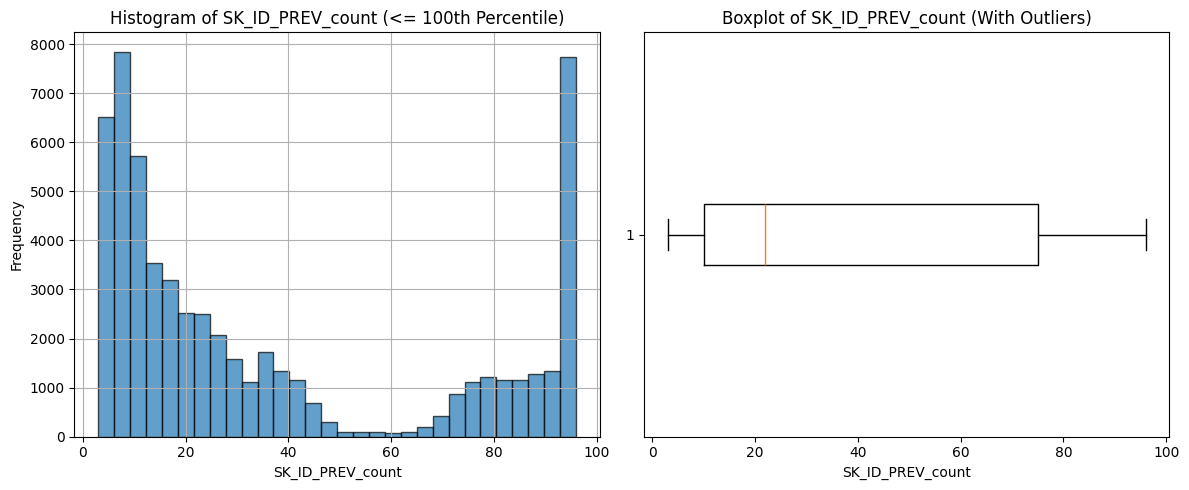

C:\Users\david\AppData\Local\Temp\ipykernel_13196\492399311.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 37.769619827924075
Mean for target=1 (Defaulter): 30.857310628302994
t-statistic: 14.046631339729734, p-value: 9.548300993931987e-45
There is a significant difference between the groups. 


Segment analysis for SK_ID_PREV_count:


C:\Users\david\AppData\Local\Temp\ipykernel_13196\492399311.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby('bin').agg({


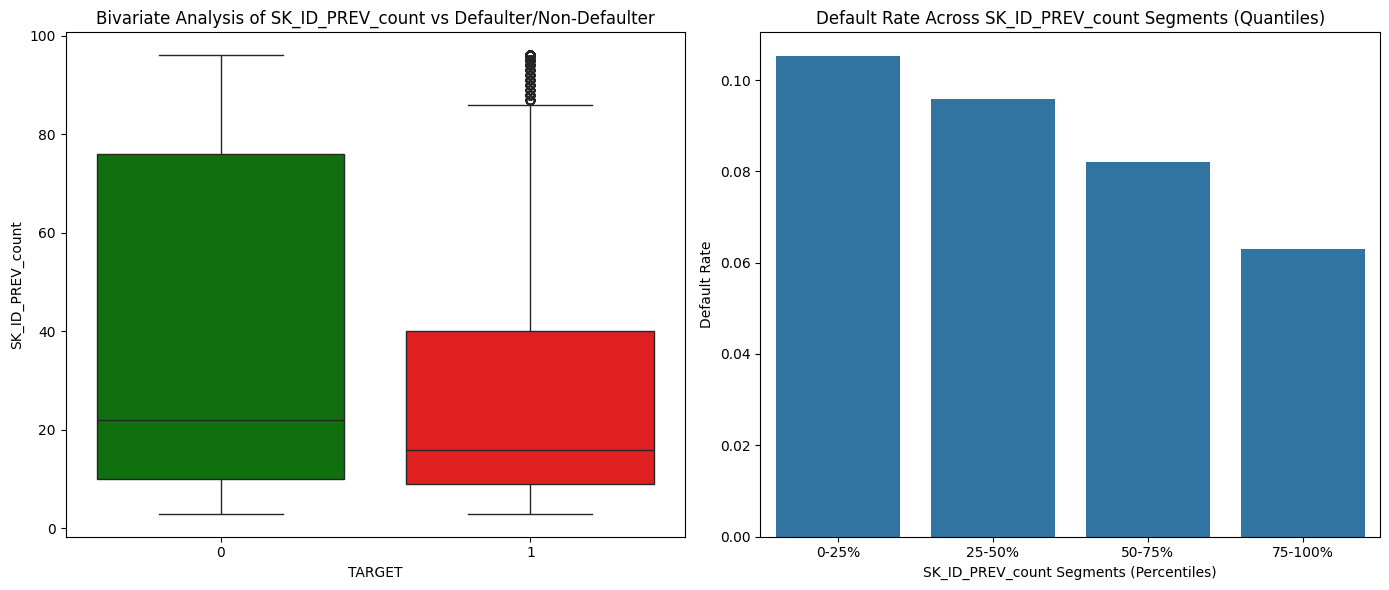

In [14]:
numerical_analysis(merged_df, "SK_ID_PREV_count", "TARGET")



**insight:**
Non-defaulters tend to have more extensive credit histories, as indicated by a higher number of credit products (SK_ID_PREV_count). This suggests they are more trusted by financial institutions, likely due to their reliable repayment behavior. Defaulters, with fewer credit products, may have limited access to credit or struggle with managing it, which correlates with higher default risk. The significant p-value confirms that credit product count is a strong predictor of default likelihood

Moderate right skew

## Recency of Activity

Chi-square test results for MONTHS_BALANCE_max and TARGET:
Chi-square statistic: 46.7086
Degrees of freedom: 3
P-value: 4.0088e-10
Result: Significant association (reject null hypothesis)



C:\Users\david\AppData\Local\Temp\ipykernel_13196\1968152082.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=discrete_feature, y=target, data=df_percentage, palette='coolwarm')


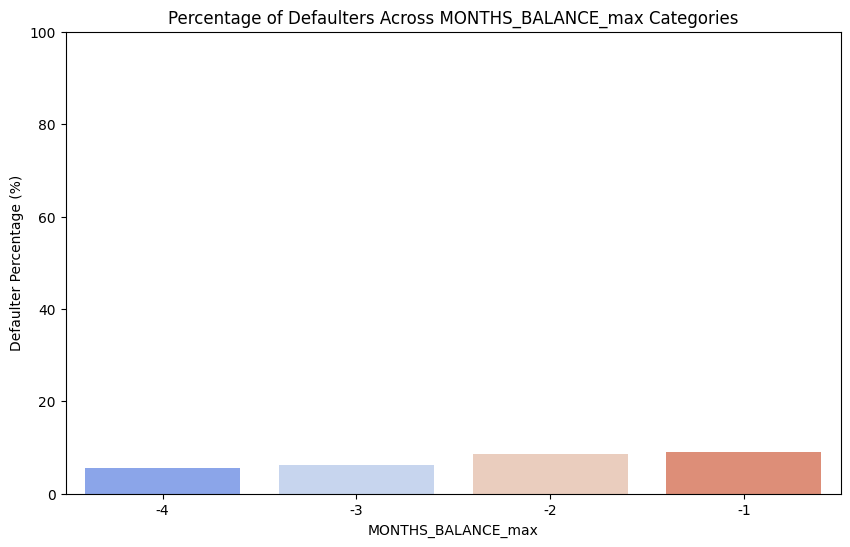

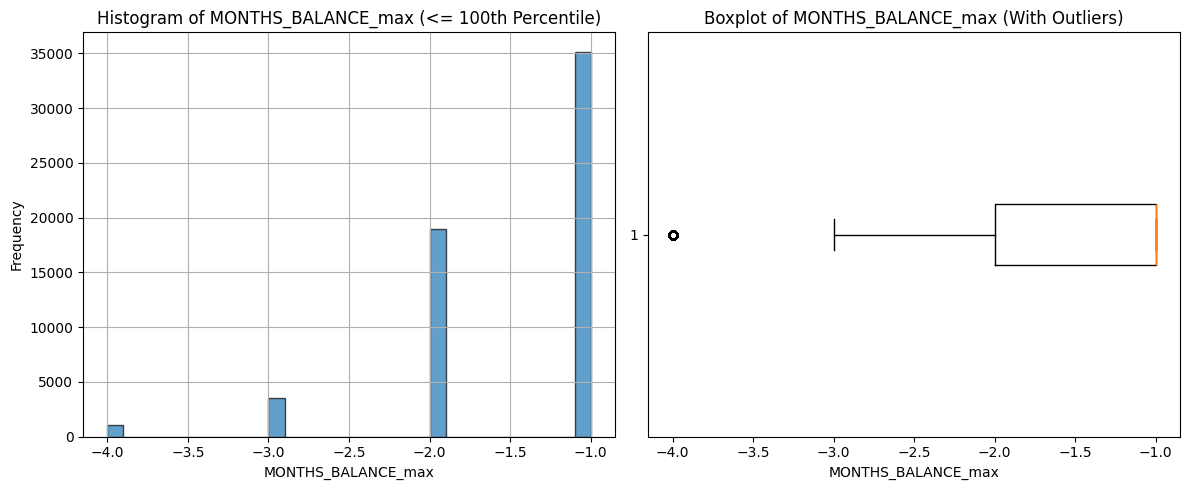

Normality Assessment for MONTHS_BALANCE_max (<= 100th Percentile):
Jarque-Bera Statistic: 25574.5313, p-value: 0.0000
Skewness: -1.3770
Kurtosis: 4.6953
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



In [15]:
from scipy.stats import chi2_contingency

def plot_defaulter_percentage(df, discrete_feature, target='TARGET'):
    """
    Plots the percentage of defaulters within each category of a discrete variable and performs a chi-square test.
    
    Parameters:
    - df: DataFrame containing the data.
    - discrete_feature: Name of the discrete variable column to analyze.
    - target: Name of the target column indicating defaulter (1) or non-defaulter (0). Default is 'TARGET'.
    """
    

    # Calculate the percentage of defaulters within each category of the discrete variable
    df_percentage = df.groupby(discrete_feature)[target].mean().reset_index()
    df_percentage[target] *= 100  # Convert to percentage
    
    # Create a contingency table for the chi-square test
    contingency_table = pd.crosstab(df[discrete_feature], df[target])
    
    # Perform the chi-square test
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Print the results of the chi-square test
    print(f"Chi-square test results for {discrete_feature} and {target}:")
    print(f"Chi-square statistic: {chi2_stat:.4f}")
    print(f"Degrees of freedom: {dof}")
    print(f"P-value: {p_value:.4e}")
    if p_value < 0.05:
        print("Result: Significant association (reject null hypothesis)\n")
    else:
        print("Result: No significant association (fail to reject null hypothesis)\n")
    
    # Plot the defaulter percentage
    plt.figure(figsize=(10, 6))
    sns.barplot(x=discrete_feature, y=target, data=df_percentage, palette='coolwarm')
    plt.title(f"Percentage of Defaulters Across {discrete_feature} Categories")
    plt.xlabel(discrete_feature)
    plt.ylabel("Defaulter Percentage (%)")
    plt.ylim(0, 100)
    plt.show()

plot_defaulter_percentage(merged_df, "MONTHS_BALANCE_max")
plot_histogram_and_boxplot(merged_df, "MONTHS_BALANCE_max")
assess_normality(merged_df, "MONTHS_BALANCE_max")

**Key Insights:**

Non-defaulters tend to have a slightly older most recent balance compared to defaulters. This could indicate that non-defaulters are less likely to have recent, up-to-date activity in their accounts, while defaulters have more recent balances recorded.

Strong left skew

**What This Could Mean**

Non-defaulters may have stable financial behavior that requires less frequent account activity, possibly because they are consistently paying off their balances or maintaining lower balances.
Defaulters, on the other hand, might have more recent activity, possibly because they are closer to or currently in financial distress, leading to more active account usage (like recent payments or balance adjustments) as they try to manage their situation.

## Credit Usage and Balance

Normality Assessment for AMT_BALANCE_sum (<= 100th Percentile):
Jarque-Bera Statistic: 44558.4763, p-value: 0.0000
Skewness: 1.7579
Kurtosis: 5.4209
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



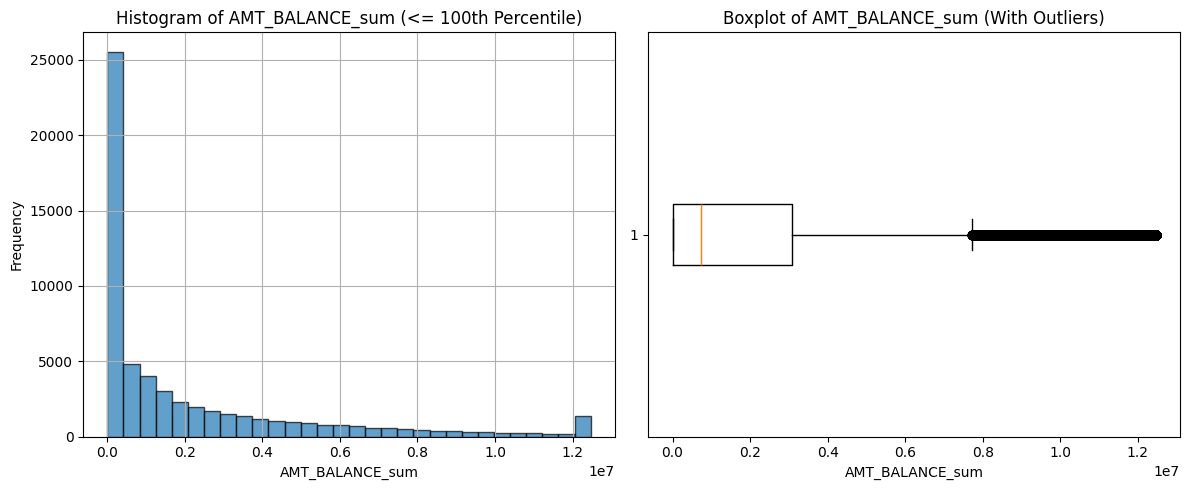

C:\Users\david\AppData\Local\Temp\ipykernel_13196\492399311.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 2130436.458657838
Mean for target=1 (Defaulter): 2371305.2450600117
t-statistic: -5.341570165179728, p-value: 9.248710430833321e-08
There is a significant difference between the groups. 



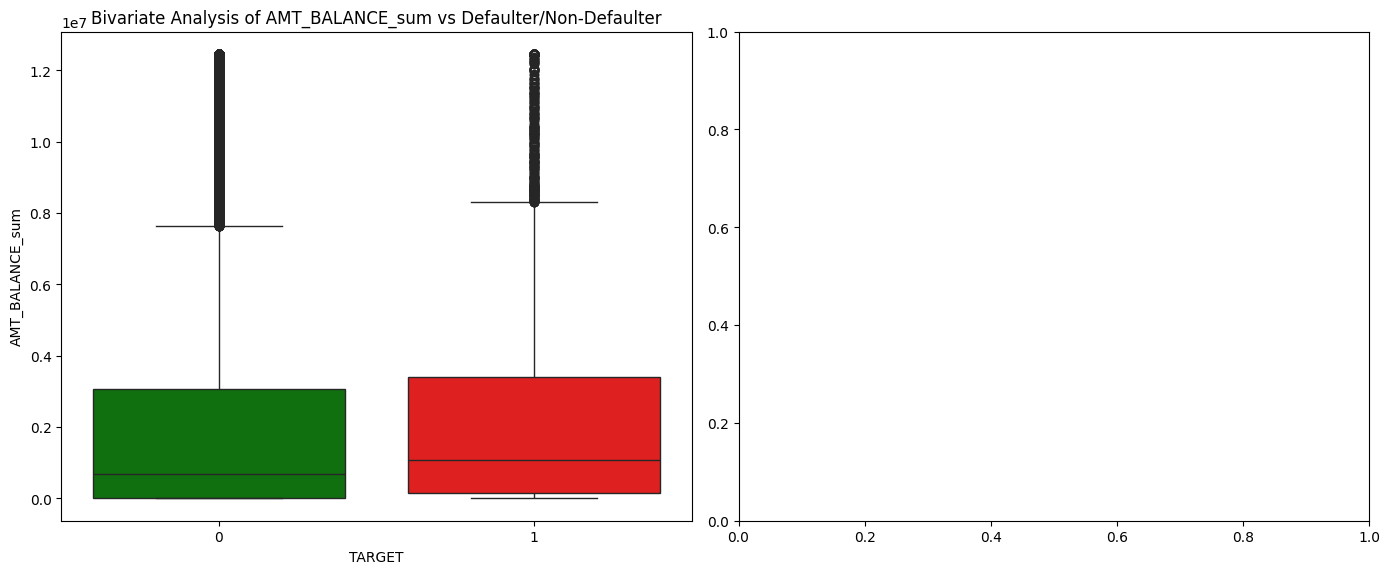

Normality Assessment for AMT_BALANCE_mean (<= 100th Percentile):
Jarque-Bera Statistic: 57813.6095, p-value: 0.0000
Skewness: 1.8662
Kurtosis: 6.1161
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



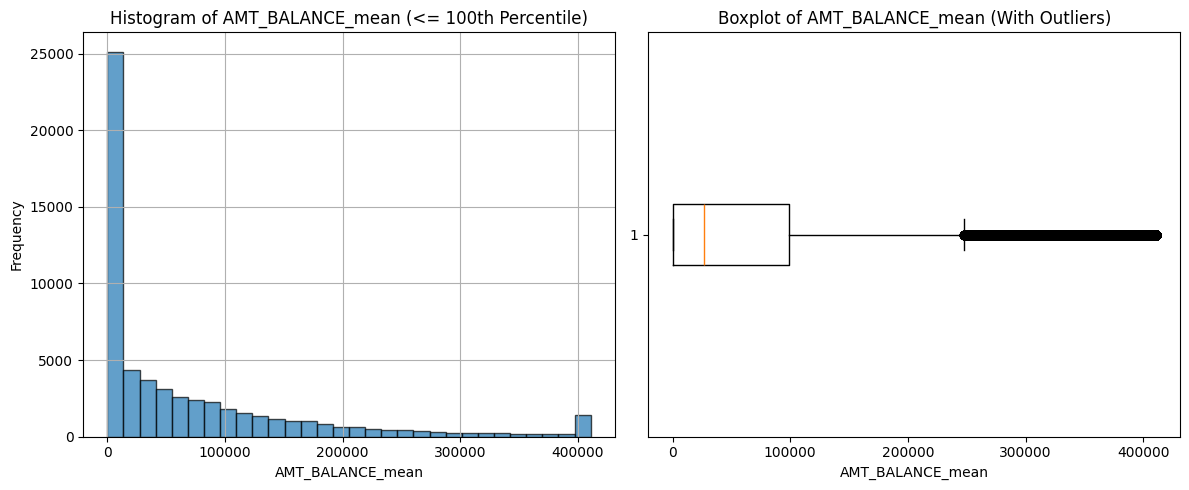

C:\Users\david\AppData\Local\Temp\ipykernel_13196\492399311.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 66233.21086389982
Mean for target=1 (Defaulter): 98058.17703034311
t-statistic: -22.4235885211019, p-value: 6.790593165586444e-111
There is a significant difference between the groups. 



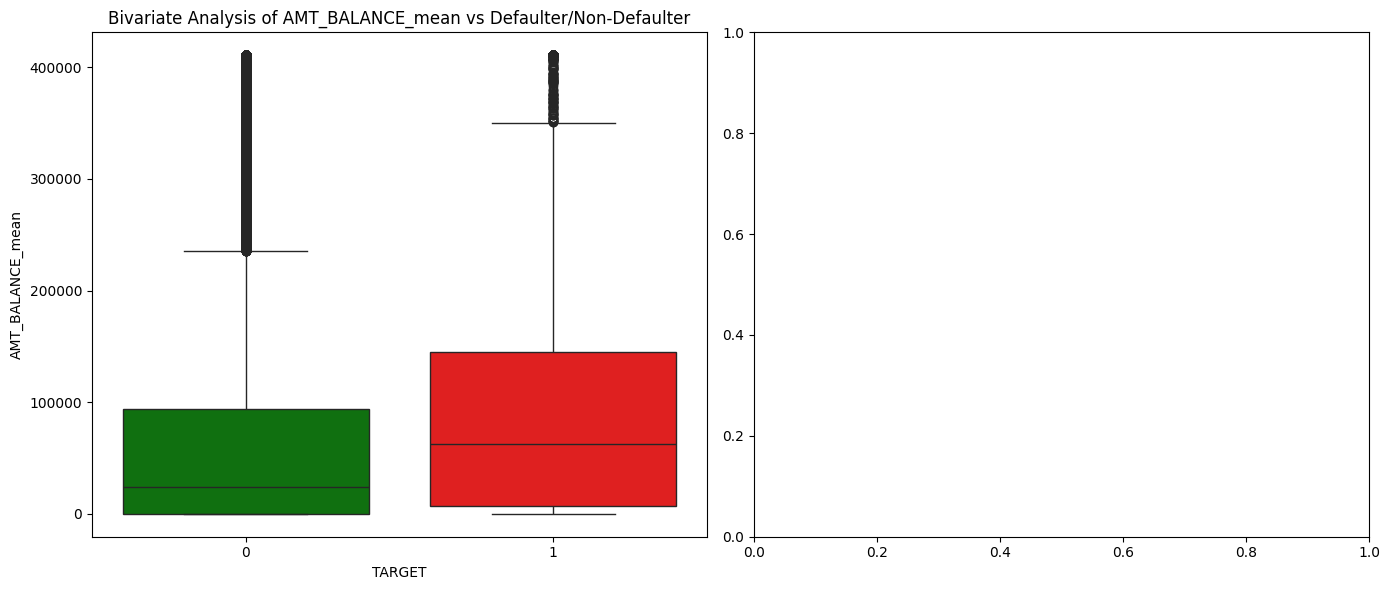

Normality Assessment for AMT_CREDIT_LIMIT_ACTUAL_mean (<= 100th Percentile):
Jarque-Bera Statistic: 36852.2005, p-value: 0.0000
Skewness: 1.6116
Kurtosis: 5.1635
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



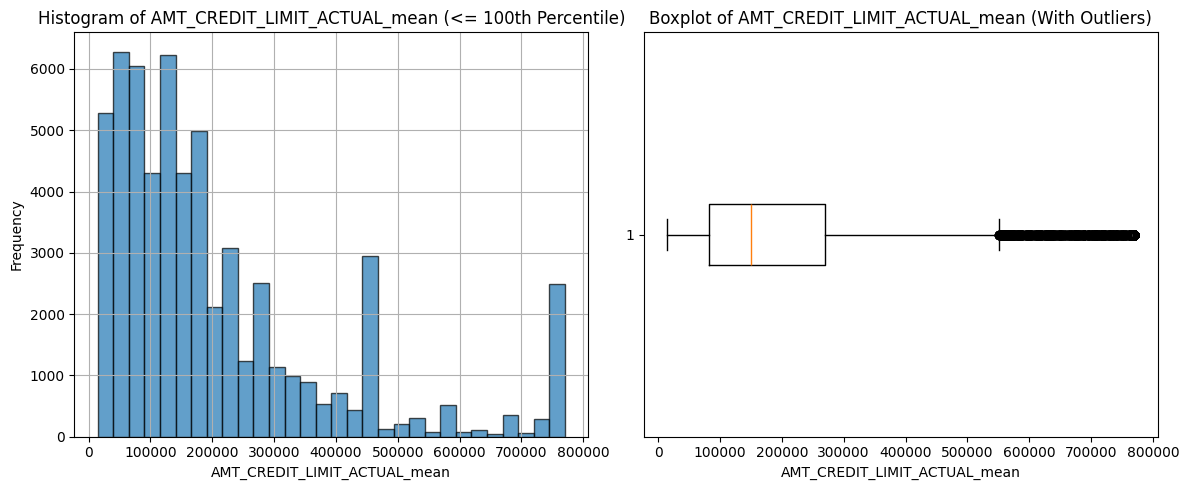

C:\Users\david\AppData\Local\Temp\ipykernel_13196\492399311.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 206572.85184444283
Mean for target=1 (Defaulter): 201136.05861032274
t-statistic: 2.028481632280086, p-value: 0.042515622425355996
There is a significant difference between the groups. 



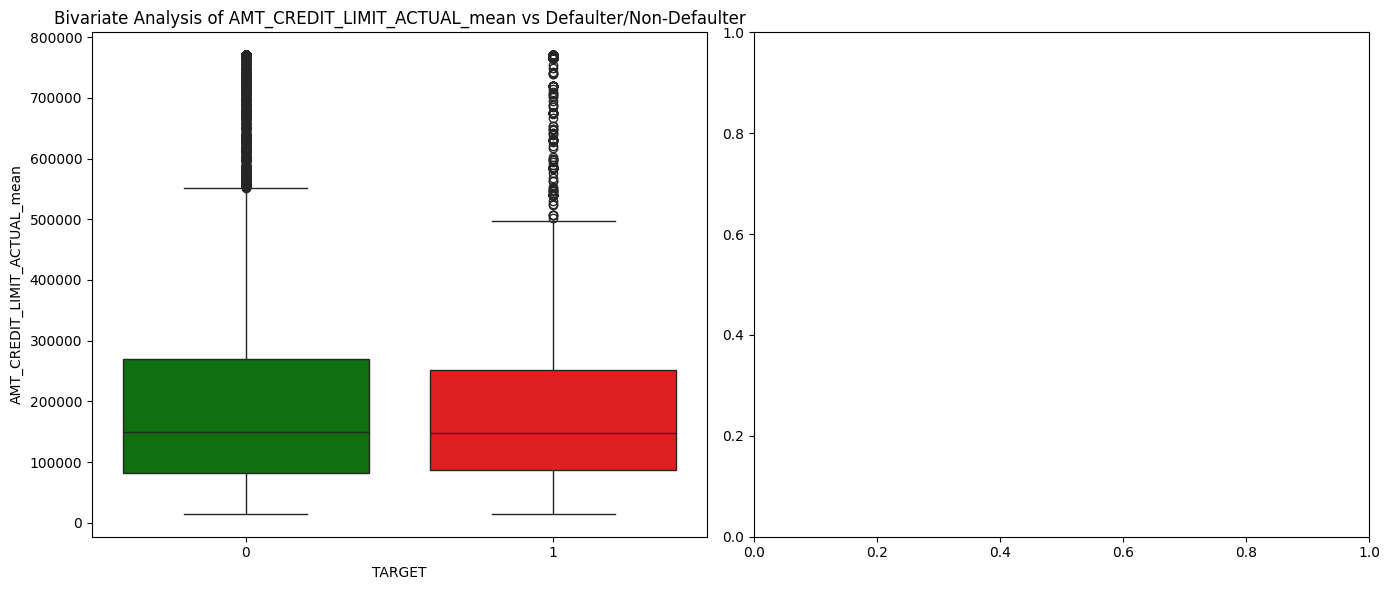

In [16]:
numerical_analysis_no_seg(merged_df, "AMT_BALANCE_sum", "TARGET")
numerical_analysis_no_seg(merged_df, "AMT_BALANCE_mean", "TARGET")
numerical_analysis_no_seg(merged_df,"AMT_CREDIT_LIMIT_ACTUAL_mean", "TARGET")

# due to the nature of the data we cannot use he existing numeric analysis function with segmentation.

### Credit Usage and Balance

**Key Insights:**

Defaulters tend to have **higher total and average balances** compared to non-defaulters, with both differences being statistically significant. Additionally, there is a **small but significant difference** in the **mean actual credit limits** between the two groups, with non-defaulters having slightly higher credit limits on average.

All features show strong right skew

**What This Could Mean:**

- **Higher total and average balances** among defaulters suggest that they may struggle to manage their debt, leading to larger outstanding amounts and a higher risk of default.
- **Lower balances** for non-defaulters imply more conservative borrowing behavior and better credit management, reducing their likelihood of default.
- The **slightly higher credit limits** for non-defaulters may reflect that financial institutions trust them with larger credit amounts due to their history of better repayment behavior, while defaulters may have their credit limits restricted.

Overall, tracking both balances and actual credit limits can provide essential insights into a borrower’s risk profile. Higher balances and lower credit limits appear to correlate with increased credit default risk.


# Credit Drawings

Normality Assessment for AMT_DRAWINGS_ATM_CURRENT_sum (<= 100th Percentile):
Jarque-Bera Statistic: 52104.8308, p-value: 0.0000
Skewness: 1.8098
Kurtosis: 5.8644
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



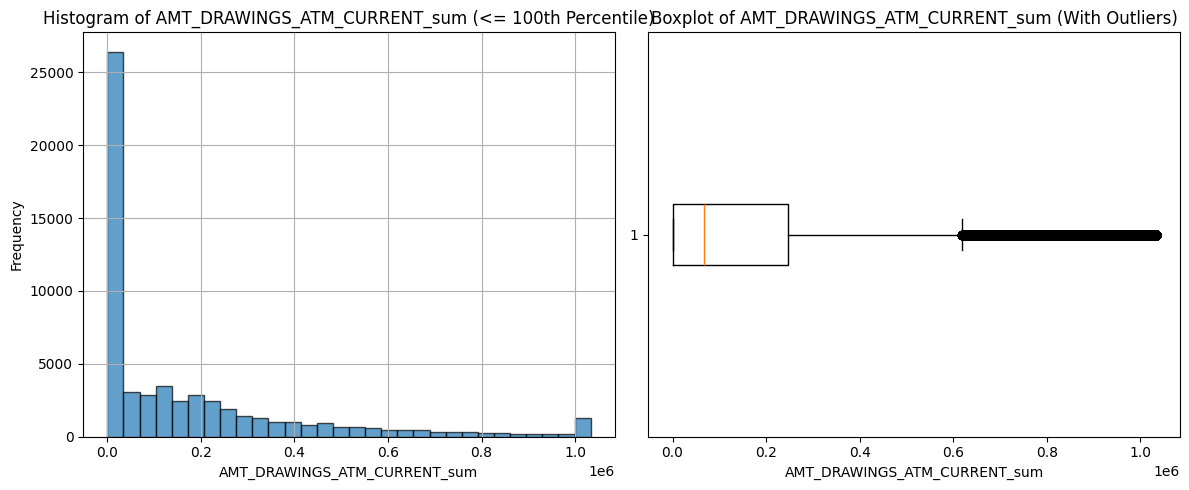

C:\Users\david\AppData\Local\Temp\ipykernel_13196\492399311.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 169976.53821550548
Mean for target=1 (Defaulter): 211784.23627715794
t-statistic: -11.60043662478175, p-value: 4.43313031267245e-31
There is a significant difference between the groups. 



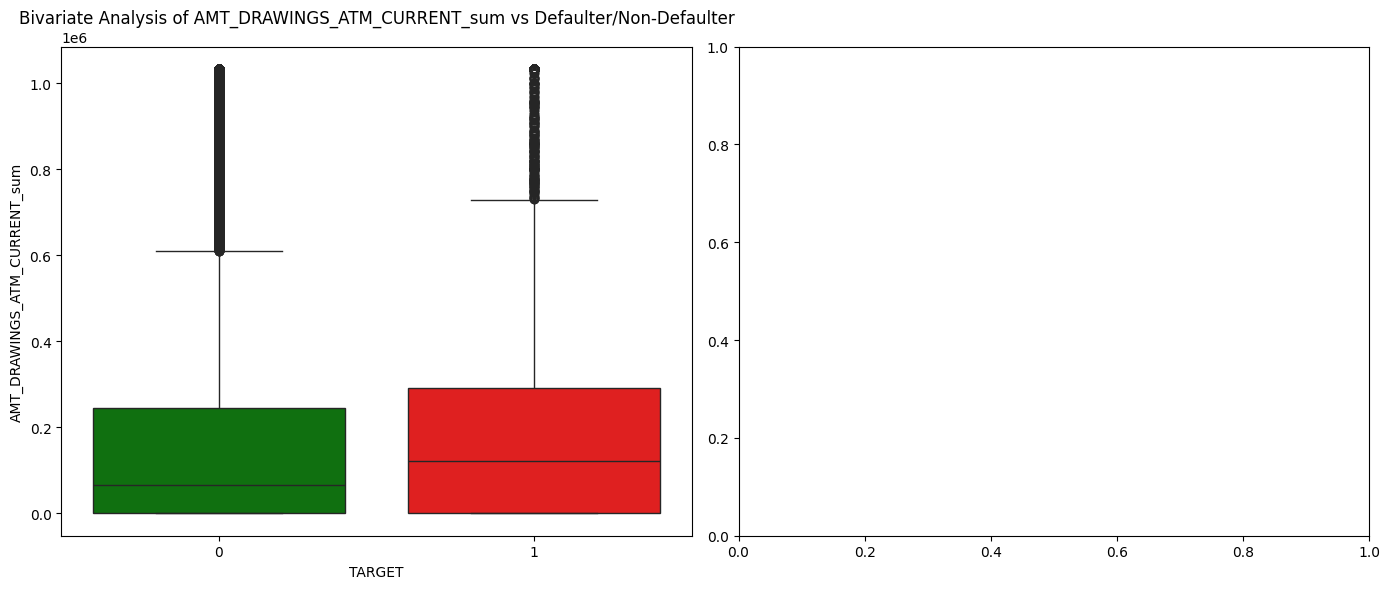

Normality Assessment for AMT_DRAWINGS_ATM_CURRENT_mean (<= 100th Percentile):
Jarque-Bera Statistic: 193289.6810, p-value: 0.0000
Skewness: 2.6273
Kurtosis: 10.1716
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



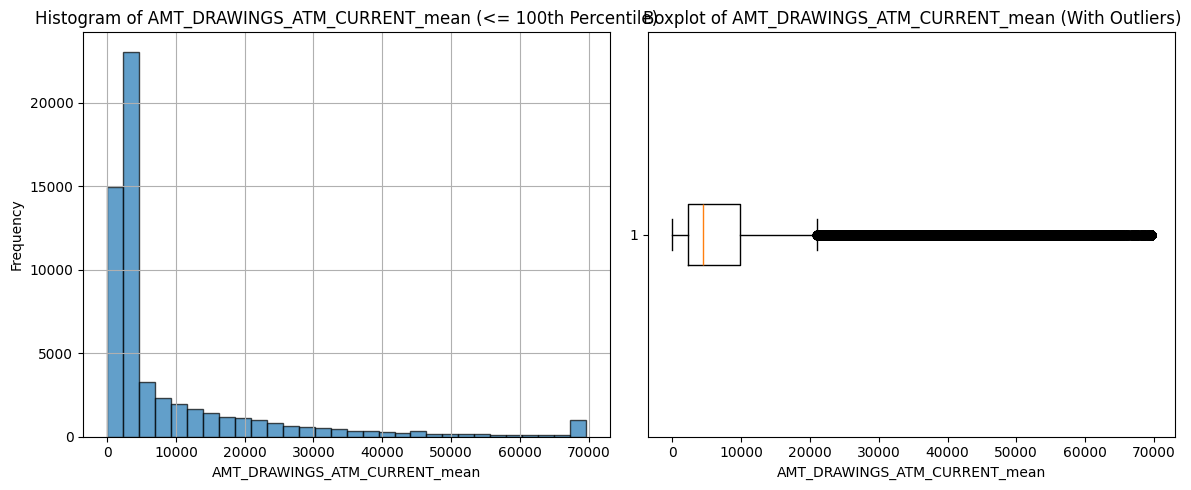

C:\Users\david\AppData\Local\Temp\ipykernel_13196\492399311.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 9059.797787311853
Mean for target=1 (Defaulter): 13161.819772689065
t-statistic: -20.69347228470093, p-value: 8.660203043583171e-95
There is a significant difference between the groups. 



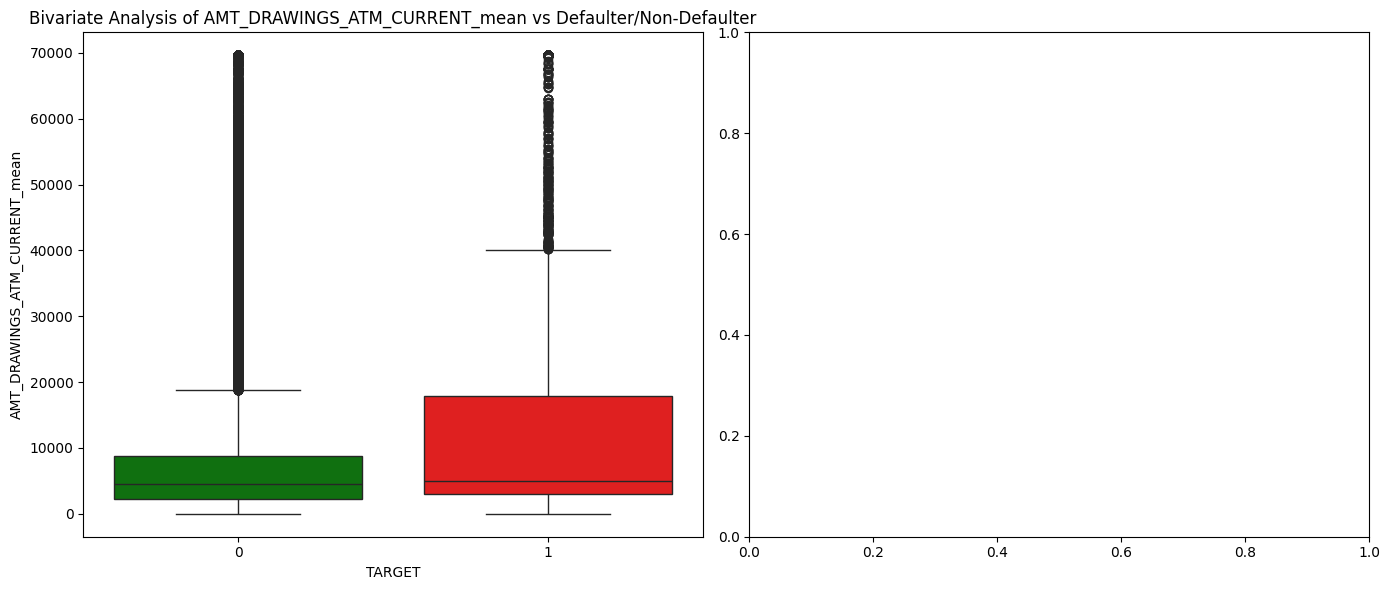

Normality Assessment for AMT_DRAWINGS_CURRENT_sum (<= 100th Percentile):
Jarque-Bera Statistic: 52984.1370, p-value: 0.0000
Skewness: 1.7933
Kurtosis: 5.9670
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



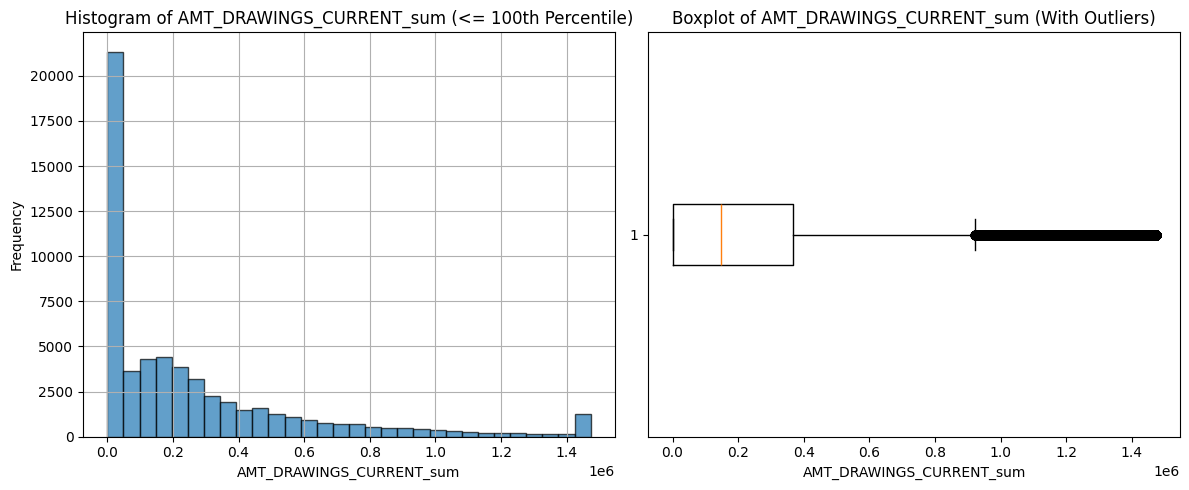

C:\Users\david\AppData\Local\Temp\ipykernel_13196\492399311.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 259064.29545821095
Mean for target=1 (Defaulter): 305095.0266139166
t-statistic: -9.242207645350744, p-value: 2.4925841949811142e-20
There is a significant difference between the groups. 



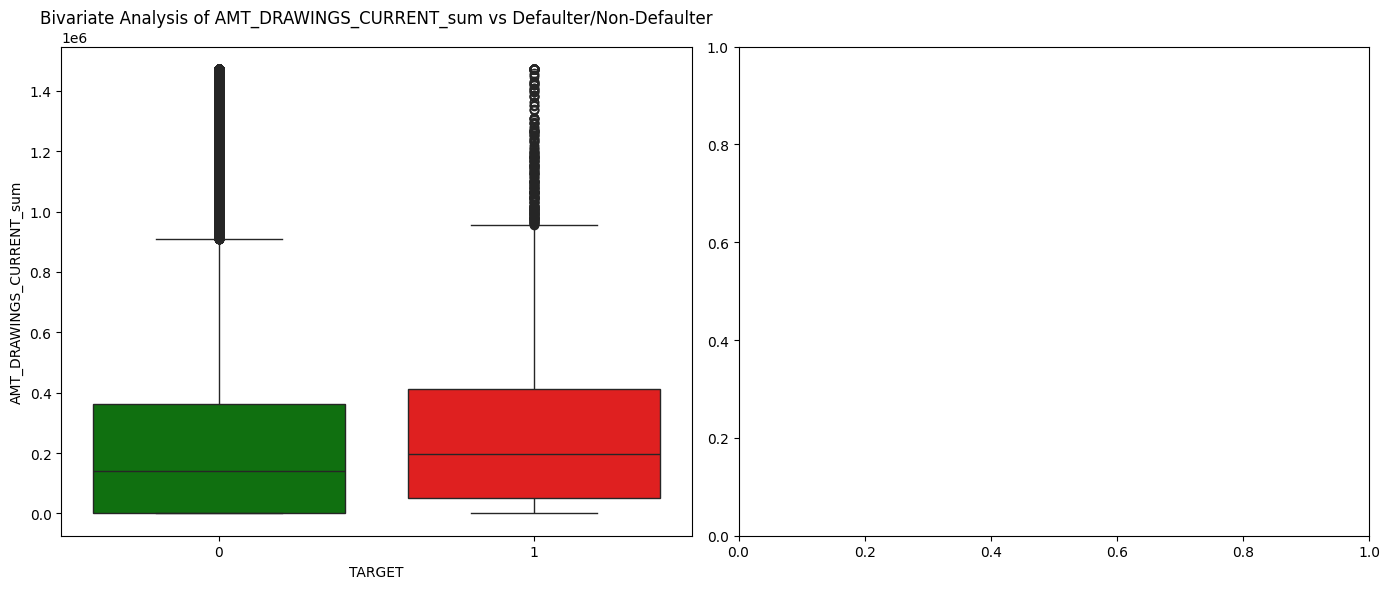

Normality Assessment for AMT_DRAWINGS_CURRENT_mean (<= 100th Percentile):
Jarque-Bera Statistic: 75853.2123, p-value: 0.0000
Skewness: 2.0213
Kurtosis: 6.8309
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



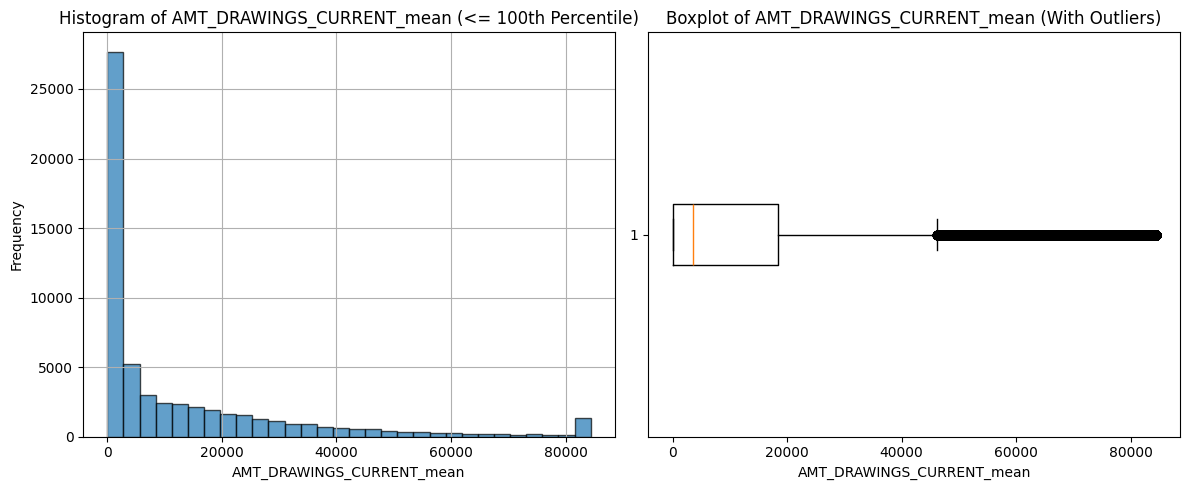

C:\Users\david\AppData\Local\Temp\ipykernel_13196\492399311.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 12411.549239977747
Mean for target=1 (Defaulter): 17965.968254197458
t-statistic: -19.675850288536953, p-value: 6.579521294531574e-86
There is a significant difference between the groups. 



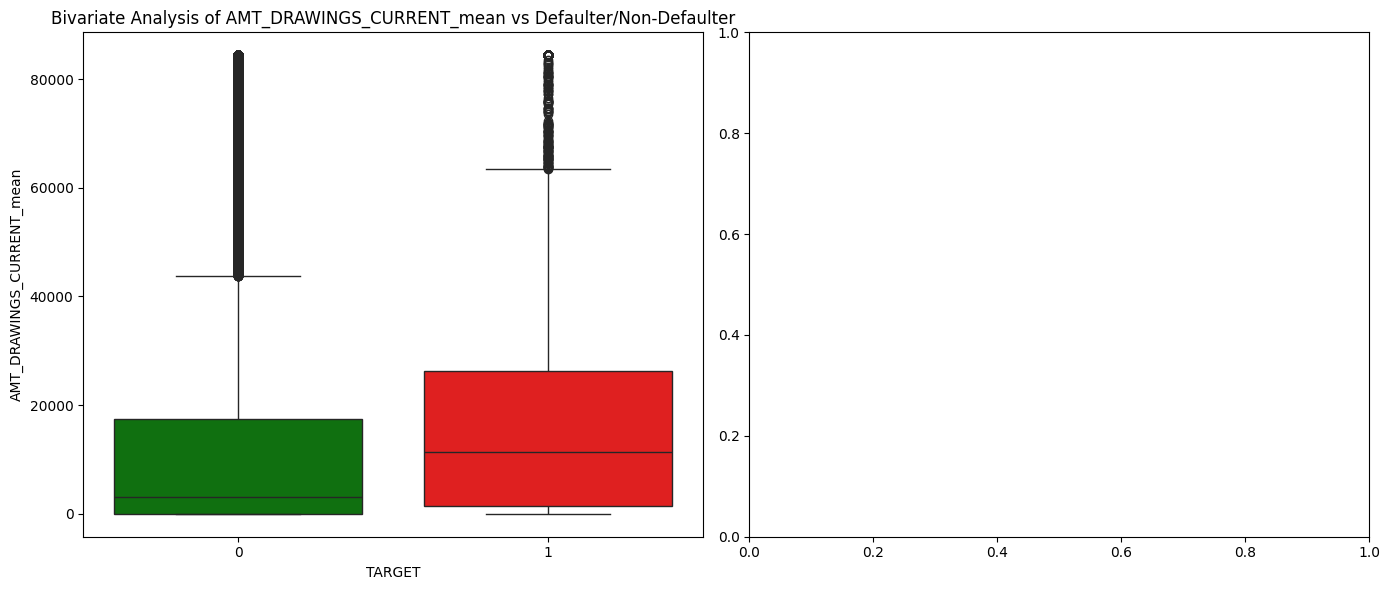

Normality Assessment for AMT_DRAWINGS_OTHER_CURRENT_sum (<= 100th Percentile):
Jarque-Bera Statistic: 1505087.4665, p-value: 0.0000
Skewness: 4.8639
Kurtosis: 25.8220
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



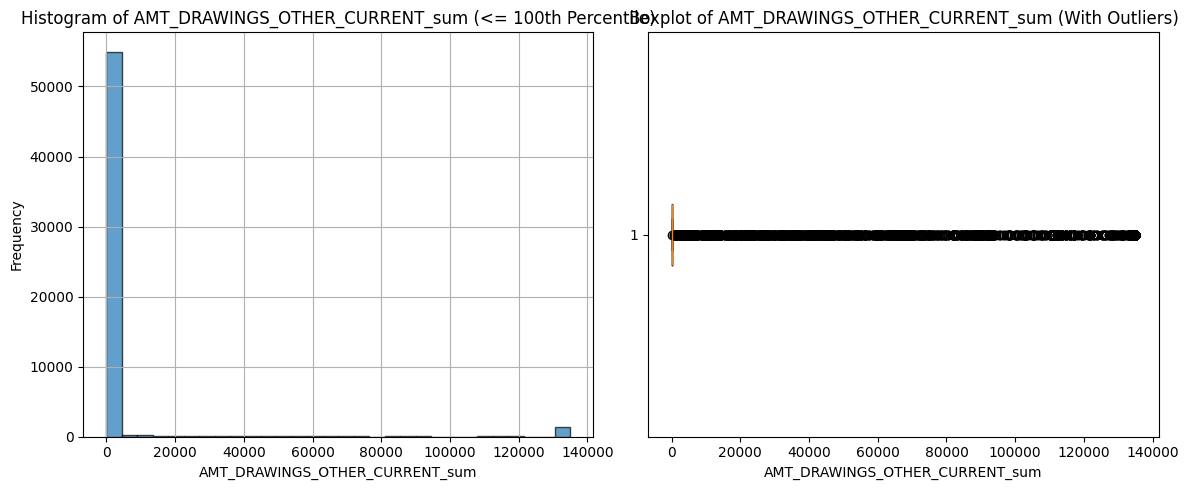

C:\Users\david\AppData\Local\Temp\ipykernel_13196\492399311.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 5037.938516918311
Mean for target=1 (Defaulter): 5881.118992953611
t-statistic: -2.4741886814003675, p-value: 0.013356720831283137
There is a significant difference between the groups. 



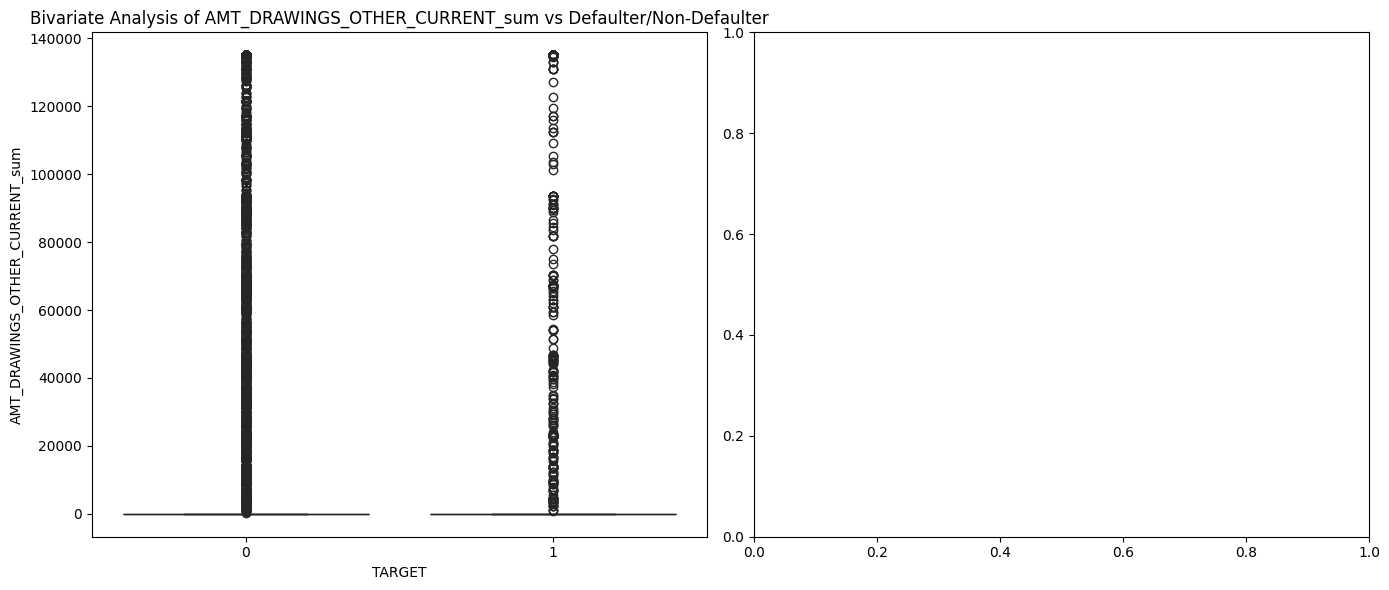

Normality Assessment for AMT_DRAWINGS_OTHER_CURRENT_mean (<= 100th Percentile):
Jarque-Bera Statistic: 3977213.7034, p-value: 0.0000
Skewness: 6.1880
Kurtosis: 41.3827
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



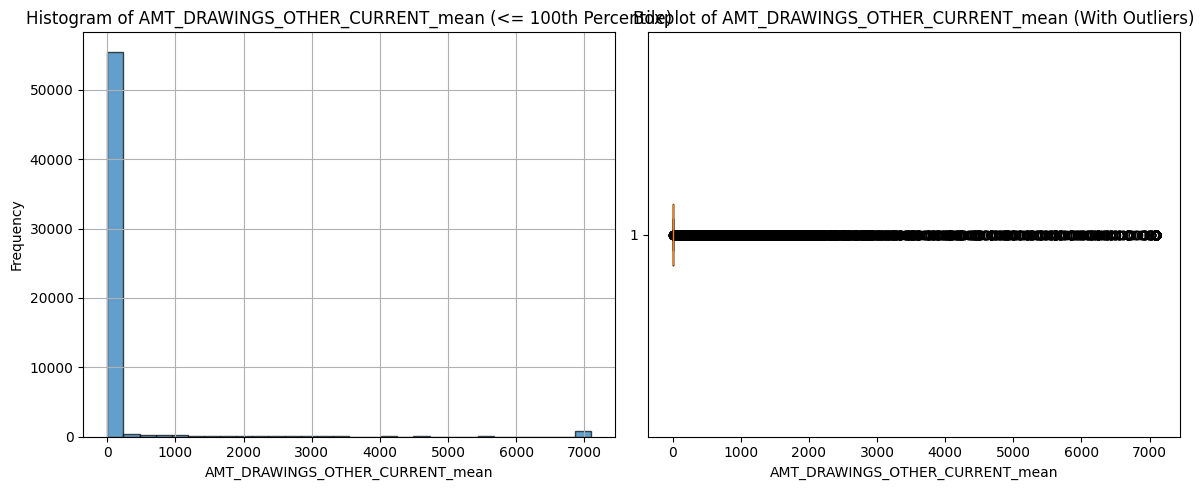

C:\Users\david\AppData\Local\Temp\ipykernel_13196\492399311.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 175.76734967173263
Mean for target=1 (Defaulter): 249.00110008076257
t-statistic: -5.073227955726666, p-value: 3.9231312682282777e-07
There is a significant difference between the groups. 



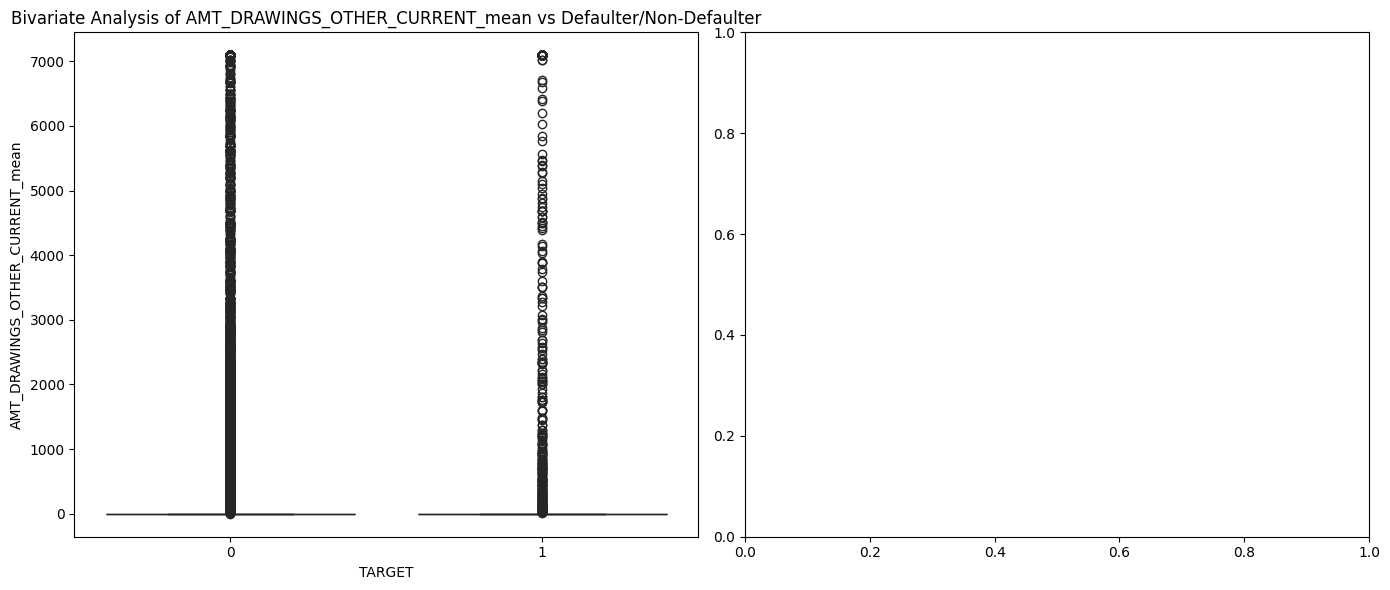

Normality Assessment for AMT_DRAWINGS_POS_CURRENT_sum (<= 100th Percentile):
Jarque-Bera Statistic: 273414.0557, p-value: 0.0000
Skewness: 2.9520
Kurtosis: 11.7721
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



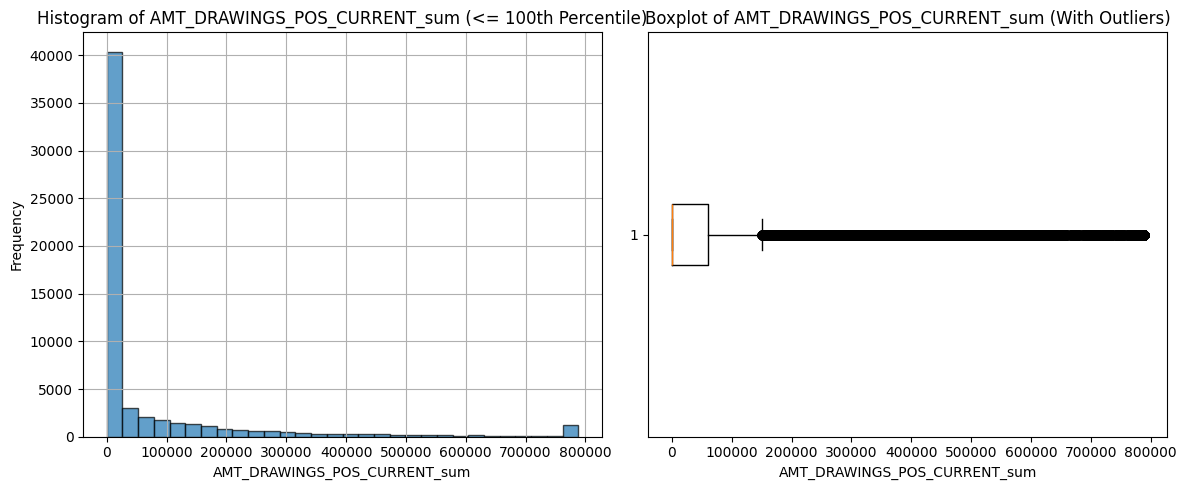

C:\Users\david\AppData\Local\Temp\ipykernel_13196\492399311.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 72139.4856296971
Mean for target=1 (Defaulter): 77248.37675654727
t-statistic: -2.1737178045972043, p-value: 0.029730318412630952
There is a significant difference between the groups. 



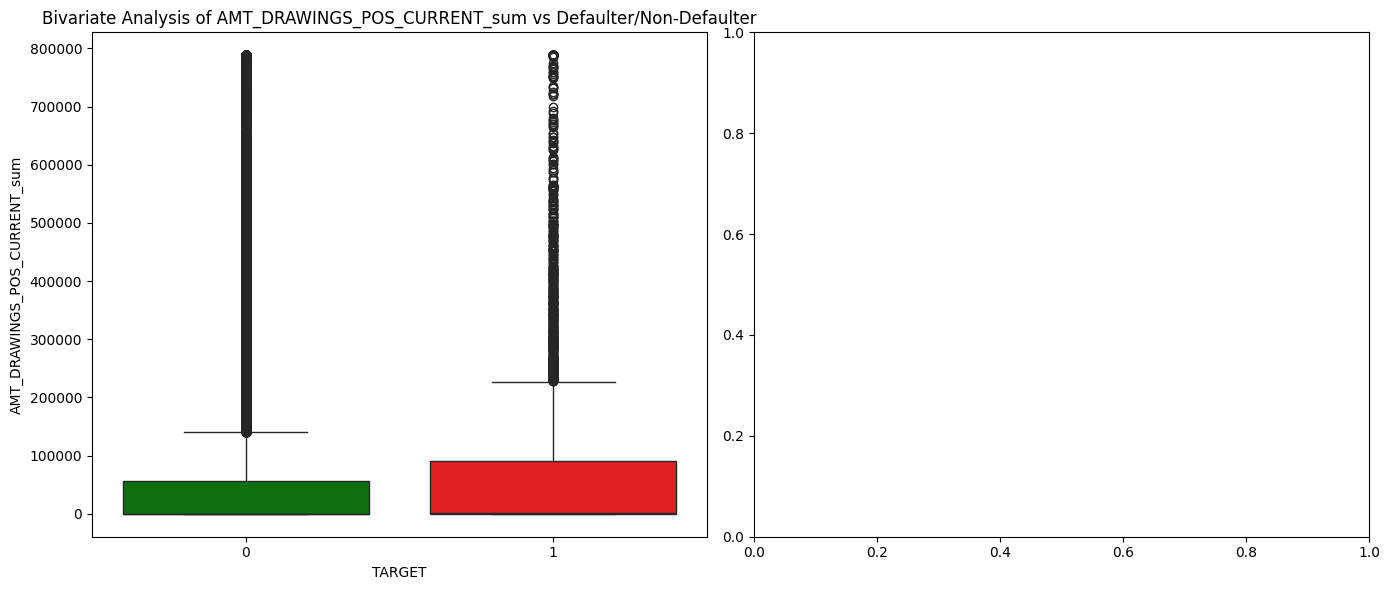

Normality Assessment for AMT_DRAWINGS_POS_CURRENT_mean (<= 100th Percentile):
Jarque-Bera Statistic: 354134.7092, p-value: 0.0000
Skewness: 3.1410
Kurtosis: 13.2641
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



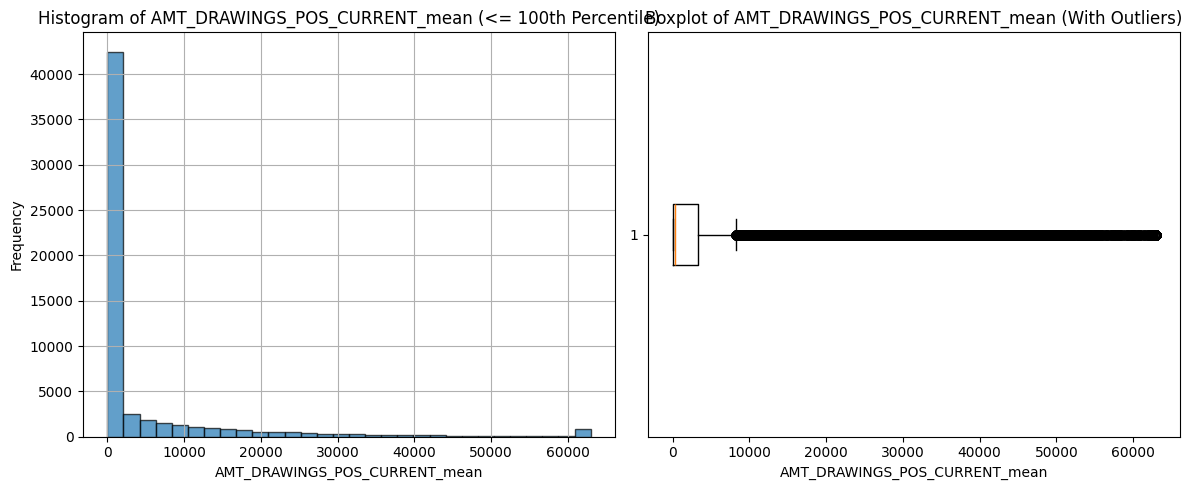

C:\Users\david\AppData\Local\Temp\ipykernel_13196\492399311.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 5132.844170016121
Mean for target=1 (Defaulter): 6149.815210242069
t-statistic: -5.862999014367697, p-value: 4.5700612948573125e-09
There is a significant difference between the groups. 



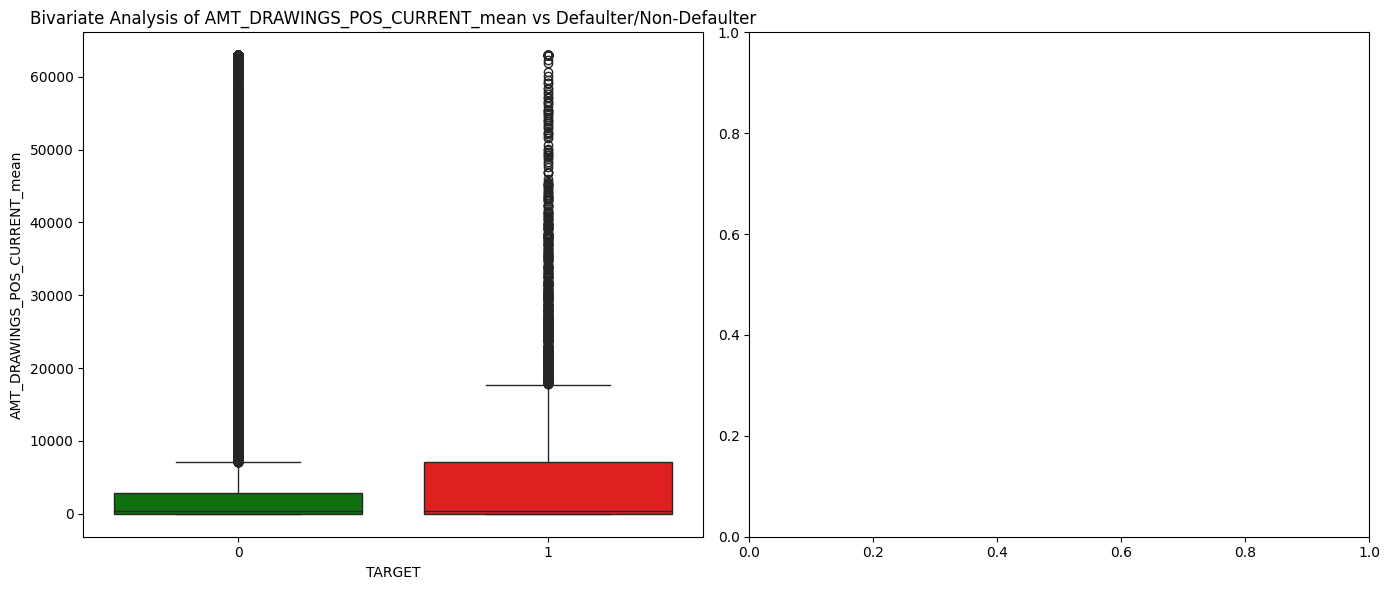

{'AMT_DRAWINGS_ATM_CURRENT_sum': None,
 'AMT_DRAWINGS_ATM_CURRENT_mean': None,
 'AMT_DRAWINGS_CURRENT_sum': None,
 'AMT_DRAWINGS_CURRENT_mean': None,
 'AMT_DRAWINGS_OTHER_CURRENT_sum': None,
 'AMT_DRAWINGS_OTHER_CURRENT_mean': None,
 'AMT_DRAWINGS_POS_CURRENT_sum': None,
 'AMT_DRAWINGS_POS_CURRENT_mean': None}

In [23]:
# Looping the function `numerical_analysis_no_seg` through the specified columns
columns = [
    "AMT_DRAWINGS_ATM_CURRENT_sum",
    "AMT_DRAWINGS_ATM_CURRENT_mean",
    "AMT_DRAWINGS_CURRENT_sum",
    "AMT_DRAWINGS_CURRENT_mean",
    "AMT_DRAWINGS_OTHER_CURRENT_sum",
    "AMT_DRAWINGS_OTHER_CURRENT_mean",
    "AMT_DRAWINGS_POS_CURRENT_sum",
    "AMT_DRAWINGS_POS_CURRENT_mean"
]

# Assuming the `numerical_analysis_no_seg` function and `merged_df` dataframe are already defined.
# The function will be applied to each column and target "TARGET"
results = {}
for column in columns:
    result = numerical_analysis_no_seg(merged_df, column, "TARGET")
    results[column] = result

results


## Key Insights from Credit Drawings 



---

### Normality and Group Differences

- Across all credit drawing features (ATM, POS, and other), the **Jarque-Bera test** consistently rejects the null hypothesis of normality, indicating non-normal distributions with significant skewness and kurtosis. 
- **Defaulters** tend to exhibit **higher sums and averages** for all types of credit drawings compared to non-defaulters. This includes **ATM withdrawals**, **POS transactions**, and **other drawings**, suggesting that defaulters engage in larger and more frequent financial transactions.
- The differences between **non-defaulters** and **defaulters** are statistically significant across all features, with **defaulters consistently overextending** their financial activities compared to non-defaulters.

---

### Conclusion:
Defaulters show a clear pattern of higher financial activity in credit drawings, likely reflecting greater financial strain or mismanagement. These differences, along with the non-normal distribution of the data, suggest that defaulters may be overextending themselves through increased transactions.


## Payments and Receivables

Analyzing AMT_PAYMENT_CURRENT_sum


C:\Users\david\AppData\Local\Temp\ipykernel_13196\1092374219.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 291883.8586328251
Mean for target=1 (Defaulter): 295305.0788582501
t-statistic: -0.6280371664086617, p-value: 0.5299820367268749
No significant difference between the groups. 

Analyzing AMT_PAYMENT_CURRENT_mean


C:\Users\david\AppData\Local\Temp\ipykernel_13196\1092374219.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 14619.844356042768
Mean for target=1 (Defaulter): 16222.250339172248
t-statistic: -6.775150182294495, p-value: 1.2544557391406838e-11
There is a significant difference between the groups. 

Analyzing AMT_PAYMENT_TOTAL_CURRENT_sum


C:\Users\david\AppData\Local\Temp\ipykernel_13196\1092374219.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 268442.53843241074
Mean for target=1 (Defaulter): 272079.05993446865
t-statistic: -0.7011963289115775, p-value: 0.4831832807584513
No significant difference between the groups. 

Analyzing AMT_PAYMENT_TOTAL_CURRENT_mean


C:\Users\david\AppData\Local\Temp\ipykernel_13196\1092374219.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 9294.71538183918
Mean for target=1 (Defaulter): 11449.379870319759
t-statistic: -10.523138324242018, p-value: 7.127058191589394e-26
There is a significant difference between the groups. 

Analyzing AMT_RECEIVABLE_PRINCIPAL_sum


C:\Users\david\AppData\Local\Temp\ipykernel_13196\1092374219.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 2045249.1607493865
Mean for target=1 (Defaulter): 2274247.424031474
t-statistic: -5.282890417534242, p-value: 1.2761386083383974e-07
There is a significant difference between the groups. 

Analyzing AMT_RECEIVABLE_PRINCIPAL_mean


C:\Users\david\AppData\Local\Temp\ipykernel_13196\1092374219.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 63726.55671704466
Mean for target=1 (Defaulter): 94078.85000773234
t-statistic: -22.160788136676302, p-value: 2.2901802487103214e-108
There is a significant difference between the groups. 

Analyzing AMT_RECIVABLE_sum


C:\Users\david\AppData\Local\Temp\ipykernel_13196\1092374219.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 2122808.77939872
Mean for target=1 (Defaulter): 2359423.937251321
t-statistic: -5.256904930263019, p-value: 1.4701133223198197e-07
There is a significant difference between the groups. 

Analyzing AMT_RECIVABLE_mean


C:\Users\david\AppData\Local\Temp\ipykernel_13196\1092374219.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 65810.88001966818
Mean for target=1 (Defaulter): 97211.64255045193
t-statistic: -22.24553708565302, p-value: 3.530451378127831e-109
There is a significant difference between the groups. 

Analyzing AMT_TOTAL_RECEIVABLE_sum


C:\Users\david\AppData\Local\Temp\ipykernel_13196\1092374219.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 2123110.4339101138
Mean for target=1 (Defaulter): 2360105.3378297123
t-statistic: -5.264752791088185, p-value: 1.4087092942725215e-07
There is a significant difference between the groups. 

Analyzing AMT_TOTAL_RECEIVABLE_mean


C:\Users\david\AppData\Local\Temp\ipykernel_13196\1092374219.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 65814.94342360106
Mean for target=1 (Defaulter): 97223.10773341806
t-statistic: -22.250416770889565, p-value: 3.169436929258285e-109
There is a significant difference between the groups. 



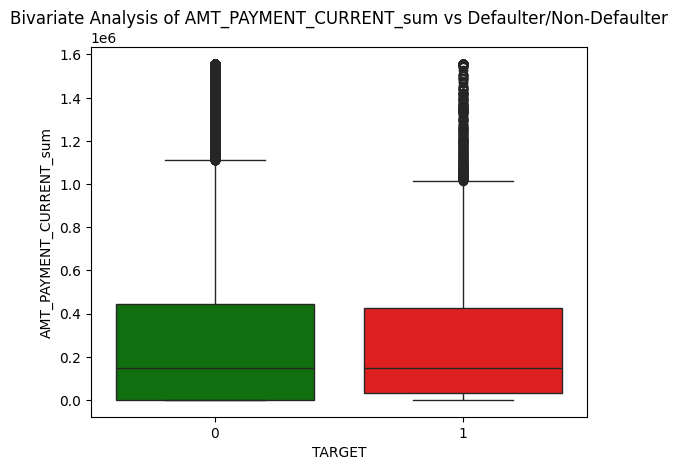

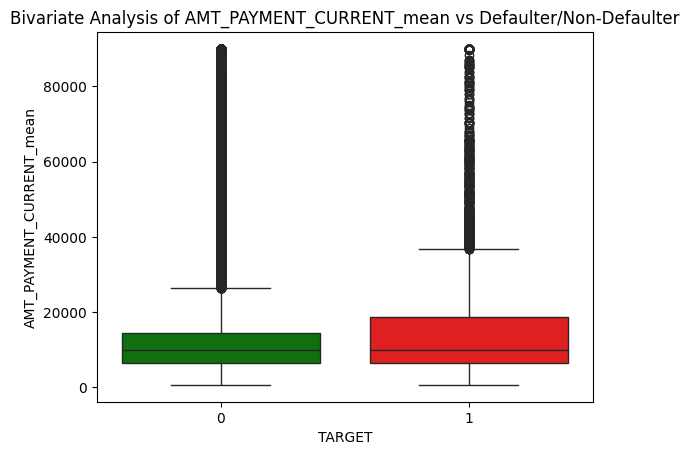

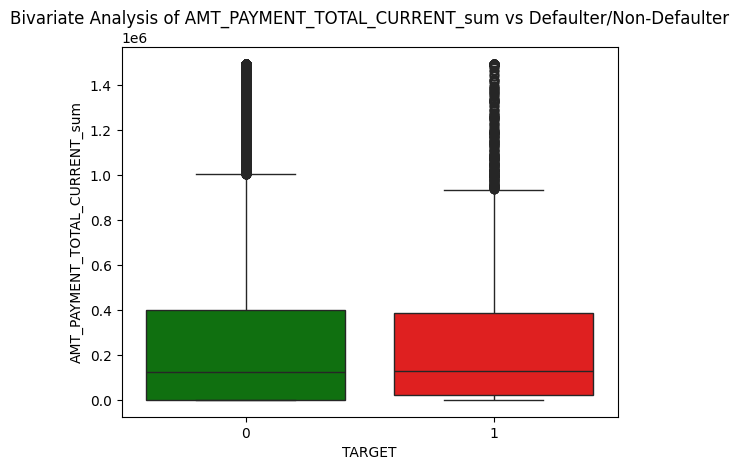

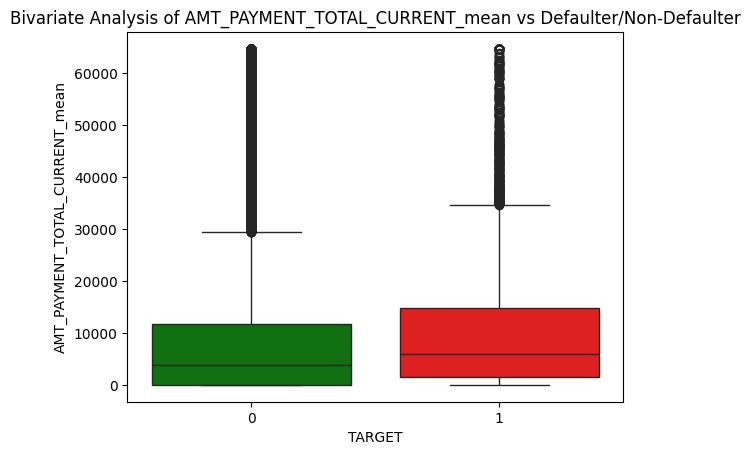

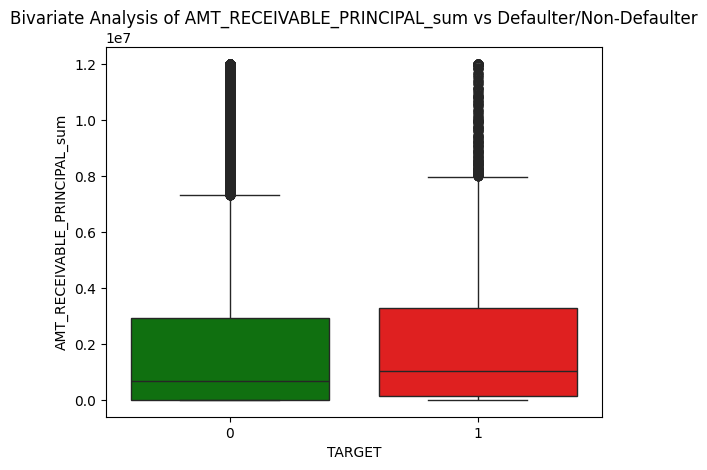

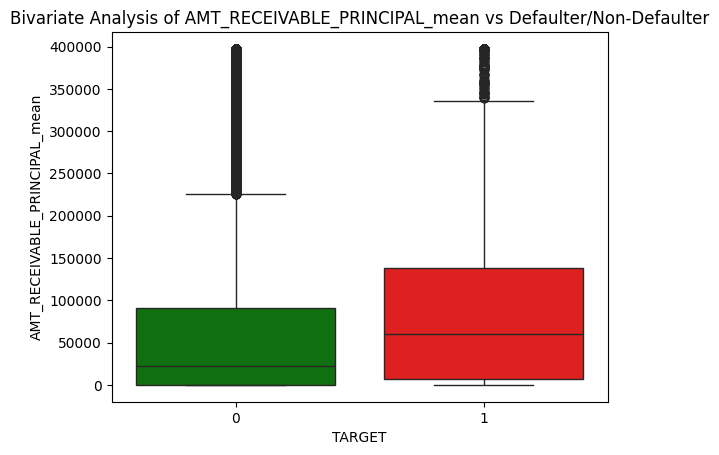

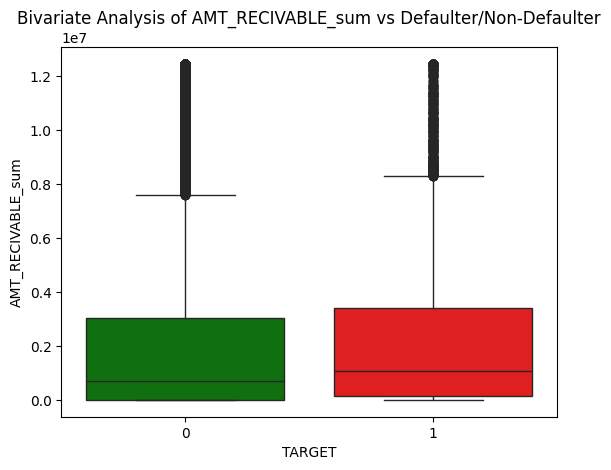

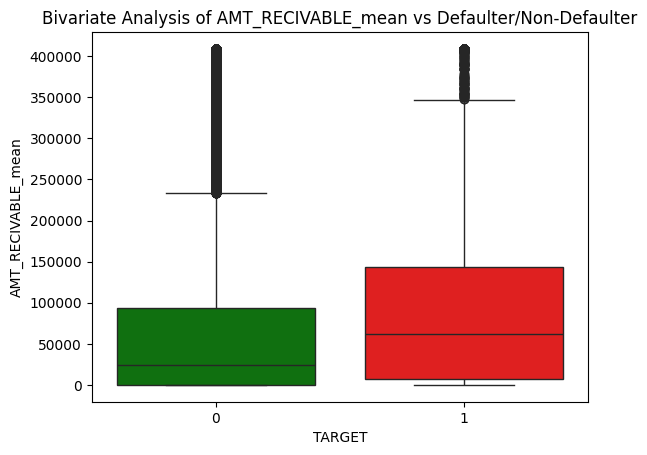

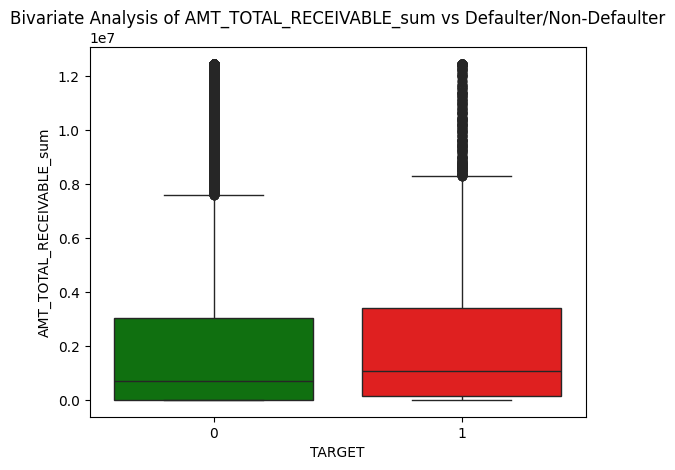

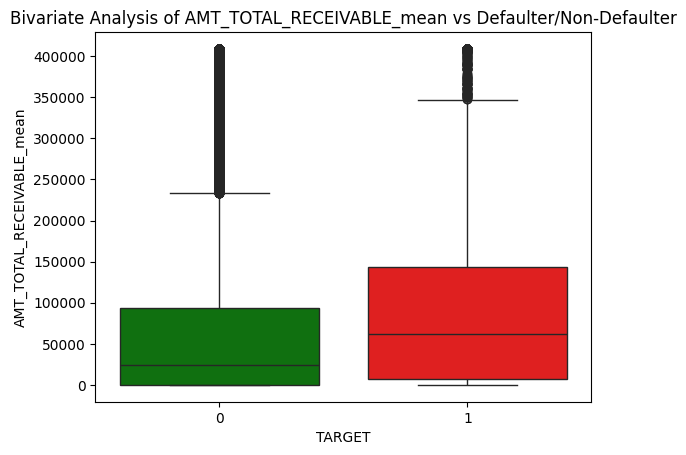

In [18]:
# List of payment and receivable columns to analyze
columns_to_analyze = [
    'AMT_PAYMENT_CURRENT_sum', 'AMT_PAYMENT_CURRENT_mean', 
    'AMT_PAYMENT_TOTAL_CURRENT_sum', 'AMT_PAYMENT_TOTAL_CURRENT_mean', 
    'AMT_RECEIVABLE_PRINCIPAL_sum', 'AMT_RECEIVABLE_PRINCIPAL_mean', 
    'AMT_RECIVABLE_sum', 'AMT_RECIVABLE_mean', 
    'AMT_TOTAL_RECEIVABLE_sum', 'AMT_TOTAL_RECEIVABLE_mean'
]

# Loop through the columns and apply bivariate_analysis
for column in columns_to_analyze:
    print(f"Analyzing {column}")
    bivariate_analysis2(merged_df, column, "TARGET")


# T-Test Analysis for Payment and Receivable Features

---

### General Insights:

When analyzing the total amount currently paid (`AMT_PAYMENT_CURRENT_sum`), there is no significant difference between defaulters and non-defaulters. This indicates that overall, the total payments made by individuals do not strongly distinguish those who default from those who don't. However, when we look at the average amount currently paid (`AMT_PAYMENT_CURRENT_mean`), we do see a significant difference. Defaulters tend to make higher average payments, which could suggest that they are taking on larger loans or perhaps struggling with financial overextension more often than non-defaulters.

For the total of all current payments (`AMT_PAYMENT_TOTAL_CURRENT_sum`), there is again no significant difference between the two groups. This suggests that the total amount being repaid across financial products is not a reliable indicator of default risk. On the other hand, the average of all current payments (`AMT_PAYMENT_TOTAL_CURRENT_mean`) does show a significant difference, with defaulters tending to have higher average payment amounts. This might reflect larger financial obligations that could be contributing to their difficulty in staying current on payments.

Looking at unpaid balances, there is a significant difference between defaulters and non-defaulters when it comes to the total unpaid principal (`AMT_RECEIVABLE_PRINCIPAL_sum`). Defaulters tend to have larger outstanding principal amounts, which indicates they are struggling more with their financial commitments. This pattern is even clearer when we analyze the average unpaid principal (`AMT_RECEIVABLE_PRINCIPAL_mean`), where we see a large and significant difference. Defaulters have much higher unpaid balances on average, highlighting a strong relationship between outstanding debt and default risk.

The total amount receivable (`AMT_RECIVABLE_sum`) also shows a significant difference between defaulters and non-defaulters, with defaulters owing more in total. This pattern is consistent when looking at the average receivables (`AMT_RECIVABLE_mean`), where defaulters again have higher amounts, reinforcing the idea that those who default are more likely to have larger unpaid balances overall.

Finally, when examining the total of all types of receivables (`AMT_TOTAL_RECEIVABLE_sum`), defaulters consistently owe more than non-defaulters, suggesting that higher total debt is a risk factor for default. The same holds true for the average total receivables (`AMT_TOTAL_RECEIVABLE_mean`), where defaulters again show significantly higher unpaid amounts, further supporting the link between larger unpaid debts and the likelihood of defaulting.

---

### Conclusion:

Overall, defaulters consistently have larger unpaid balances and higher average payment amounts, indicating that they are more financially overextended. While total payments may not always show a clear difference, the averages and unpaid amounts clearly distinguish defaulters from non-defaulters. Larger financial obligations, particularly in the form of unpaid receivables, are key indicators of default risk.


## Drawings and Installment Counts

Analyzing CNT_DRAWINGS_ATM_CURRENT_sum


C:\Users\david\AppData\Local\Temp\ipykernel_13196\1092374219.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 8.883092887404118
Mean for target=1 (Defaulter): 11.547269524368762
t-statistic: -13.863587138596062, p-value: 1.2337870139960424e-43
There is a significant difference between the groups. 

Analyzing CNT_DRAWINGS_CURRENT_sum


C:\Users\david\AppData\Local\Temp\ipykernel_13196\1092374219.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 23.178178832048673
Mean for target=1 (Defaulter): 32.216284987277355
t-statistic: -16.531127309994446, p-value: 3.0144106878517423e-61
There is a significant difference between the groups. 

Analyzing CNT_DRAWINGS_OTHER_CURRENT_sum


C:\Users\david\AppData\Local\Temp\ipykernel_13196\1092374219.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 0.09251413747410463
Mean for target=1 (Defaulter): 0.10217263652378156
t-statistic: -1.7662993681297399, p-value: 0.07735083529077696
No significant difference between the groups. 

Analyzing CNT_DRAWINGS_POS_CURRENT_sum


C:\Users\david\AppData\Local\Temp\ipykernel_13196\1092374219.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 13.712174091562307
Mean for target=1 (Defaulter): 19.999021334899197
t-statistic: -12.996112846923198, p-value: 1.455284022565871e-38
There is a significant difference between the groups. 

Analyzing CNT_INSTALMENT_MATURE_CUM_sum


C:\Users\david\AppData\Local\Temp\ipykernel_13196\1092374219.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 723.615457718221
Mean for target=1 (Defaulter): 554.4609864944216
t-statistic: 9.548373716533407, p-value: 1.3659715090452073e-21
There is a significant difference between the groups. 



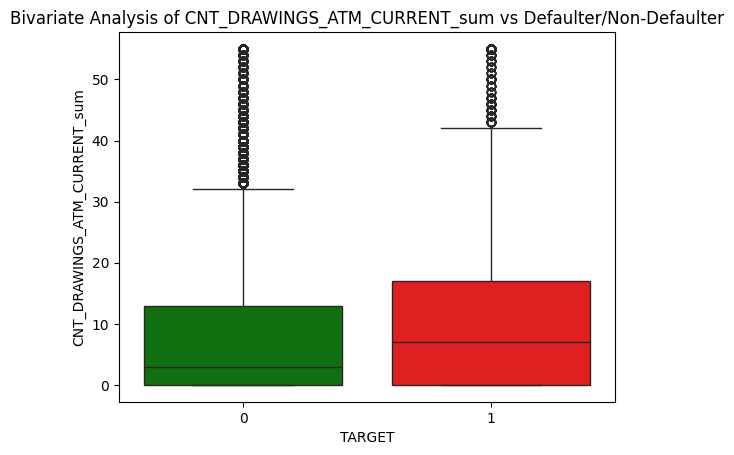

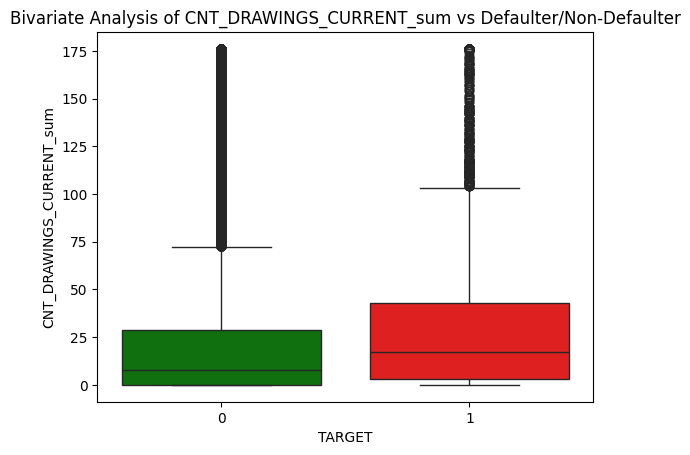

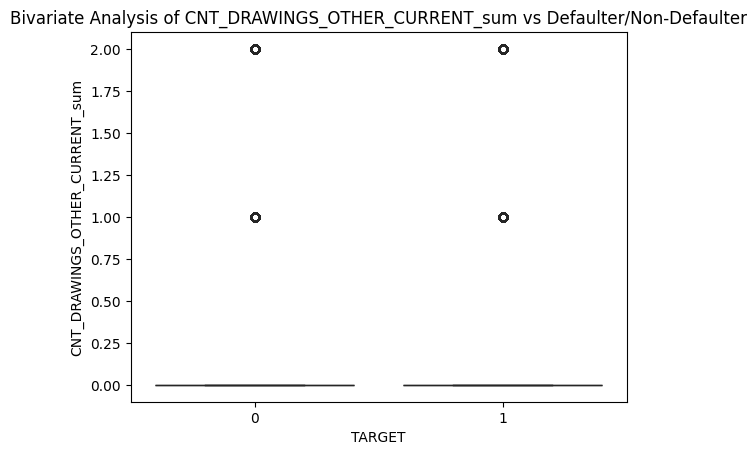

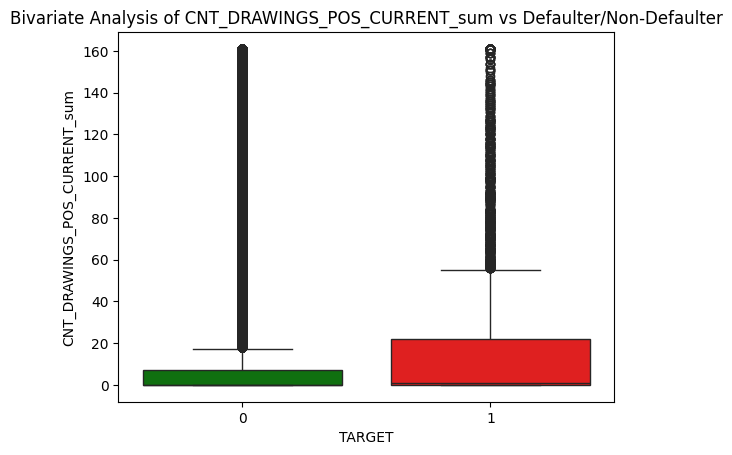

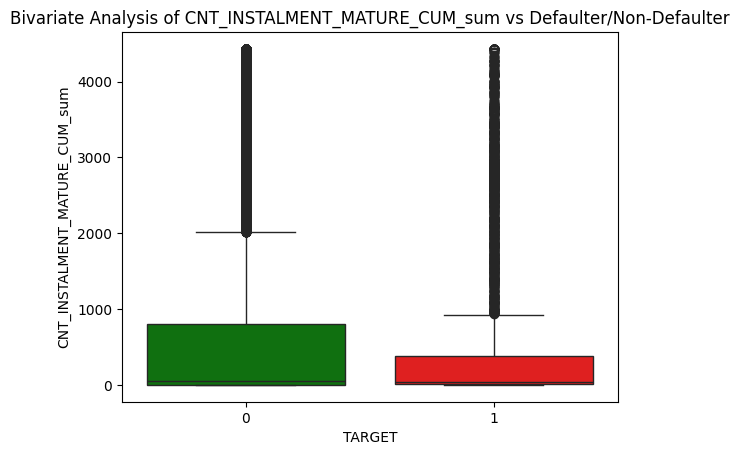

In [20]:
# List of drawing and installment count columns to analyze
columns_to_analyze = [
    'CNT_DRAWINGS_ATM_CURRENT_sum',
    'CNT_DRAWINGS_CURRENT_sum',
    'CNT_DRAWINGS_OTHER_CURRENT_sum',
    'CNT_DRAWINGS_POS_CURRENT_sum',
    'CNT_INSTALMENT_MATURE_CUM_sum'
]

# Loop through the columns and apply bivariate_analysis function
for column in columns_to_analyze:
    print(f"Analyzing {column}")
    bivariate_analysis2(merged_df, column, "TARGET")



### Analysis of Drawings and Installments Count Features

---

The analysis reveals key differences between defaulters and non-defaulters.

- **ATM Drawings (CNT_DRAWINGS_ATM_CURRENT_sum)**:  
  There is a **significant difference**. Defaulters make more ATM withdrawals, which may indicate financial stress or overreliance on cash access.

- **Total Drawings (CNT_DRAWINGS_CURRENT_sum)**:  
  A **significant difference** is found here as well. Defaulters withdraw more often, possibly indicating overextension or financial pressure.

- **Other Drawings (CNT_DRAWINGS_OTHER_CURRENT_sum)**:  
  There is **no significant difference** between the two groups. This suggests other types of drawings (non-ATM or non-POS) do not heavily influence default risk.

- **POS Drawings (CNT_DRAWINGS_POS_CURRENT_sum)**:  
  A **significant difference** is observed. Defaulters make more POS transactions, which could indicate higher daily spending or financial pressure.

- **Matured Installments (CNT_INSTALMENT_MATURE_CUM_sum)**:  
  There is a **significant difference**. Non-defaulters have more matured installments, showing better financial management and payment consistency.

---

### Conclusion

Defaulters exhibit higher drawing activity, especially in ATM and POS transactions. This suggests financial strain. Non-defaulters manage their matured installments better, which shows more consistent financial behavior. These differences are important for assessing credit risk.

## Delinquencies

C:\Users\david\AppData\Local\Temp\ipykernel_13196\1092374219.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 2.349302924544148
Mean for target=1 (Defaulter): 2.4084948130749657
t-statistic: -0.40501234337942243, p-value: 0.6854699140466943
No significant difference between the groups. 



C:\Users\david\AppData\Local\Temp\ipykernel_13196\1092374219.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 0.3194975830984864
Mean for target=1 (Defaulter): 0.41182227441769426
t-statistic: -5.541767927753712, p-value: 3.0071566639282255e-08
There is a significant difference between the groups. 



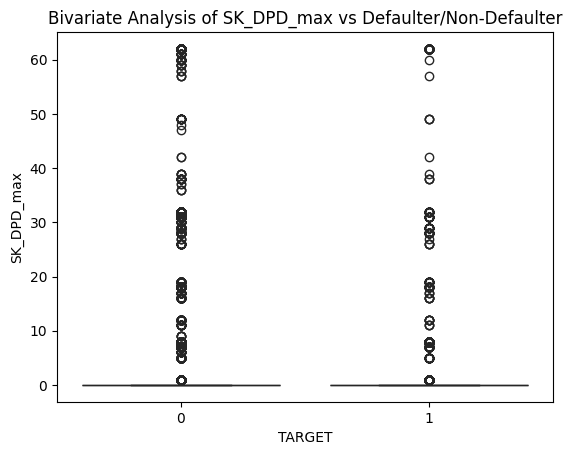

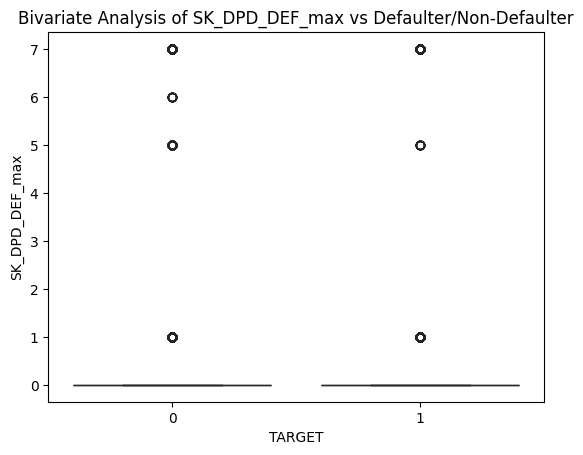

In [22]:
# Applying bivariate analysis on delinquencies columns
bivariate_analysis2(merged_df, "SK_DPD_max", "TARGET")
bivariate_analysis2(merged_df, "SK_DPD_DEF_max", "TARGET")


### Delinquencies Analysis

---

The analysis of delinquencies reveals mixed results between the two variables:

- **SK_DPD_max (Maximum Days Past Due)**:
  - There is **no significant difference** between defaulters and non-defaulters in terms of maximum days past due. This indicates that both groups have similar delinquency behavior when considering the maximum number of days they are overdue.

- **SK_DPD_DEF_max (Maximum Days Past Due with Defaults)**:
  - A **significant difference** is observed between defaulters and non-defaulters. Defaulters have more days past due with defaults compared to non-defaulters. This suggests that defaulting customers tend to have a more serious delinquency history, as indicated by their higher maximum number of days overdue with defaults.

---

### Conclusion

The significant difference found in **SK_DPD_DEF_max** highlights the predictive power of delinquency-related features, especially in identifying customers with a history of defaults. The similarity in **SK_DPD_max** suggests that simply having overdue payments may not be as strongly correlated with defaulting unless it is coupled with actual defaults. Therefore, focusing on features like **SK_DPD_DEF_max** might provide better insights into default risk.


## Contract-Status and Flag-Columns (Categorical Variables)

In [24]:
# function for categorical analysis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

def plot_categorical_distribution(df, column_name, target='TARGET'):
    """Plots the distribution of a categorical feature against the target variable with percentages."""
    print("\n" * 3)
    print(df[column_name].value_counts())
    
    # Create a normalized crosstab to calculate the percentages
    percentages = pd.crosstab(df[column_name], df[target], normalize='index') * 100
    
    # Reshape the data for plotting
    percentages = percentages.reset_index().melt(
        id_vars=column_name, 
        value_vars=[0, 1], 
        var_name='Loan Status', 
        value_name='Percentage'
    )
    
    # Map the values for better readability
    percentages['Loan Status'] = percentages['Loan Status'].map({0: 'Non-defaulter', 1: 'Defaulter'})
    
    # Create a bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=column_name, 
        y='Percentage', 
        hue='Loan Status', 
        data=percentages, 
        palette={'Non-defaulter': 'green', 'Defaulter': 'red'}
    )
    
    # Add percentages on top of the bars
    for index, row in percentages.iterrows():
        plt.text(
            x=index % len(percentages[column_name].unique()), 
            y=row['Percentage'] + 0.5,  # Adjust for better visibility
            s=f"{row['Percentage']:.1f}%", 
            ha='center', 
            va='bottom'
        )
    
    plt.title(f'Distribution of {column_name} by Loan Status (Percentage)')
    plt.xlabel(column_name)
    plt.ylabel('Percentage')
    plt.legend(title='Loan Status')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def chi_square_test(df, column_name, target='TARGET'):
    """Performs a chi-square test of independence between a categorical feature and the target."""
    # Create a contingency table
    contingency_table = pd.crosstab(df[column_name], df[target])
    
    # Perform the chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    return chi2, p, dof, expected

def categorical_analysis(df, column_name, target='TARGET', significance_level=0.05):
    """Runs both plotting and chi-square test on a single column."""
    plot_categorical_distribution(df, column_name, target)
    
    chi2, p, dof, expected = chi_square_test(df, column_name, target)
    
    print(f'Chi-square Test for {column_name}:')
    print(f'Chi2 statistic: {chi2:.4f}, p-value: {p:.4f}, Degrees of freedom: {dof}')
    
    # Check if the result is statistically significant
    is_significant = p < significance_level
    if is_significant:
        print(f"There is a significant difference between defaulters and non-defaulters for this variable ({column_name}).")
    else:
        print(f"No significant difference between defaulters and non-defaulters for this variable ({column_name}).")
    
    return is_significant


Analyzing NAME_CONTRACT_STATUS_<lambda>:




NAME_CONTRACT_STATUS_<lambda>
Active       58023
Completed      592
Signed          64
Demand          11
Name: count, dtype: int64


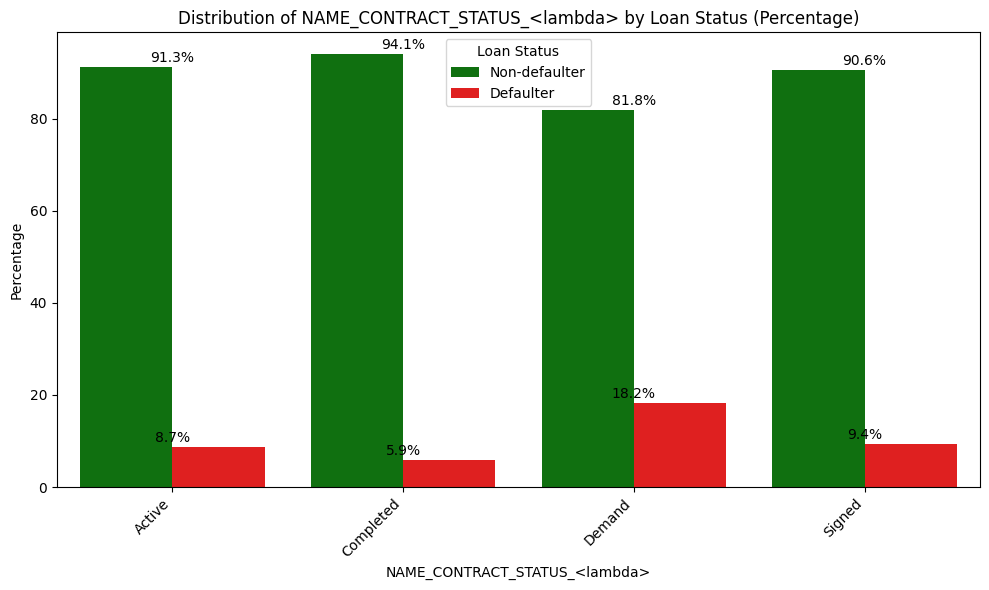

Chi-square Test for NAME_CONTRACT_STATUS_<lambda>:
Chi2 statistic: 7.1389, p-value: 0.0676, Degrees of freedom: 3
No significant difference between defaulters and non-defaulters for this variable (NAME_CONTRACT_STATUS_<lambda>).

Analyzing FLAG_AMT_PAYMENT_CURRENT_mean:




FLAG_AMT_PAYMENT_CURRENT_mean
1    41292
0    17398
Name: count, dtype: int64


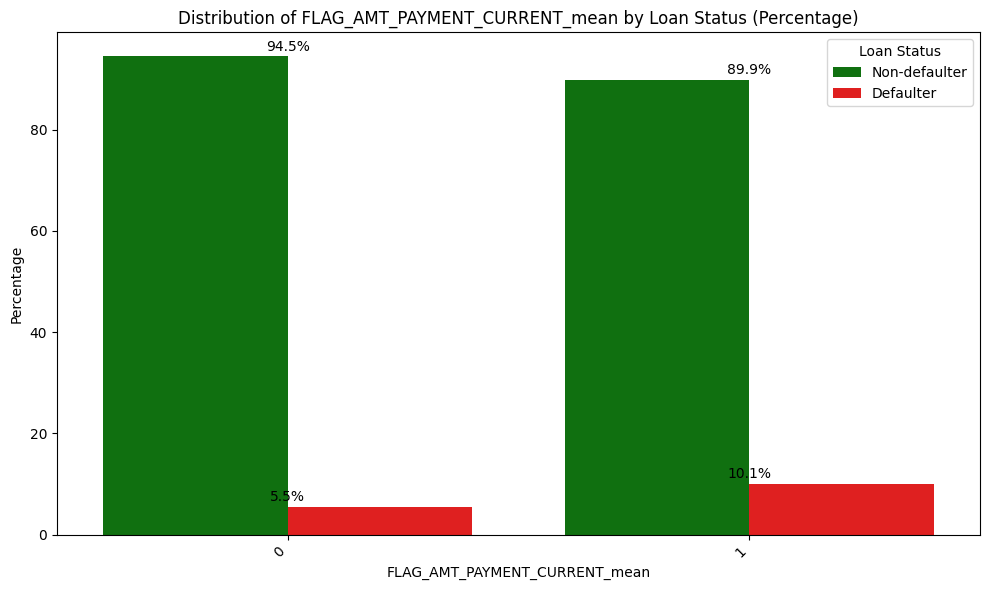

Chi-square Test for FLAG_AMT_PAYMENT_CURRENT_mean:
Chi2 statistic: 327.0005, p-value: 0.0000, Degrees of freedom: 1
There is a significant difference between defaulters and non-defaulters for this variable (FLAG_AMT_PAYMENT_CURRENT_mean).

Analyzing FLAG_AMT_DRAWINGS_POS_CURRENT_mean:




FLAG_AMT_DRAWINGS_POS_CURRENT_mean
1    41367
0    17323
Name: count, dtype: int64


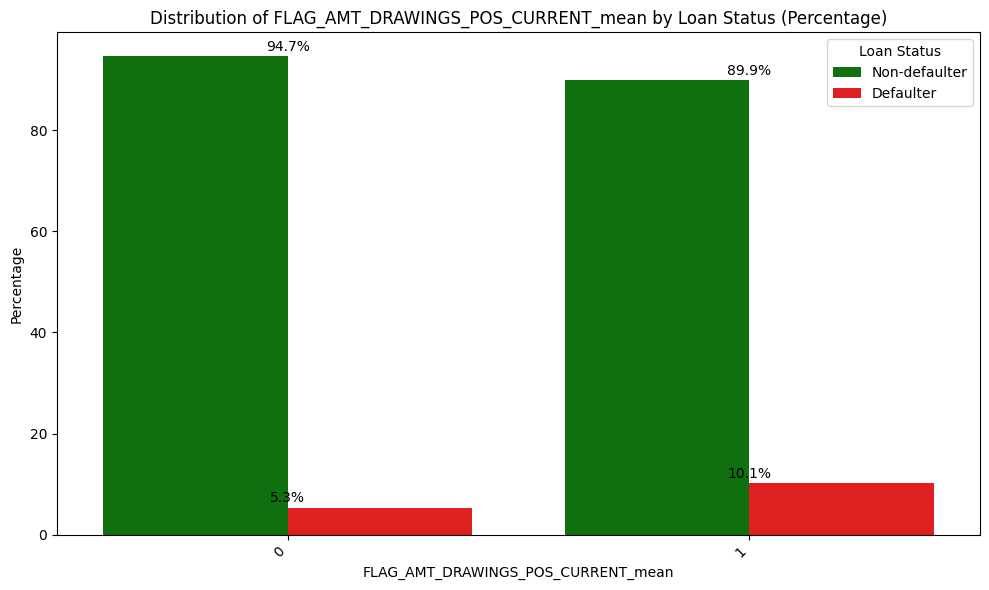

Chi-square Test for FLAG_AMT_DRAWINGS_POS_CURRENT_mean:
Chi2 statistic: 352.0499, p-value: 0.0000, Degrees of freedom: 1
There is a significant difference between defaulters and non-defaulters for this variable (FLAG_AMT_DRAWINGS_POS_CURRENT_mean).

Analyzing FLAG_AMT_DRAWINGS_OTHER_CURRENT_mean:




FLAG_AMT_DRAWINGS_OTHER_CURRENT_mean
1    41367
0    17323
Name: count, dtype: int64


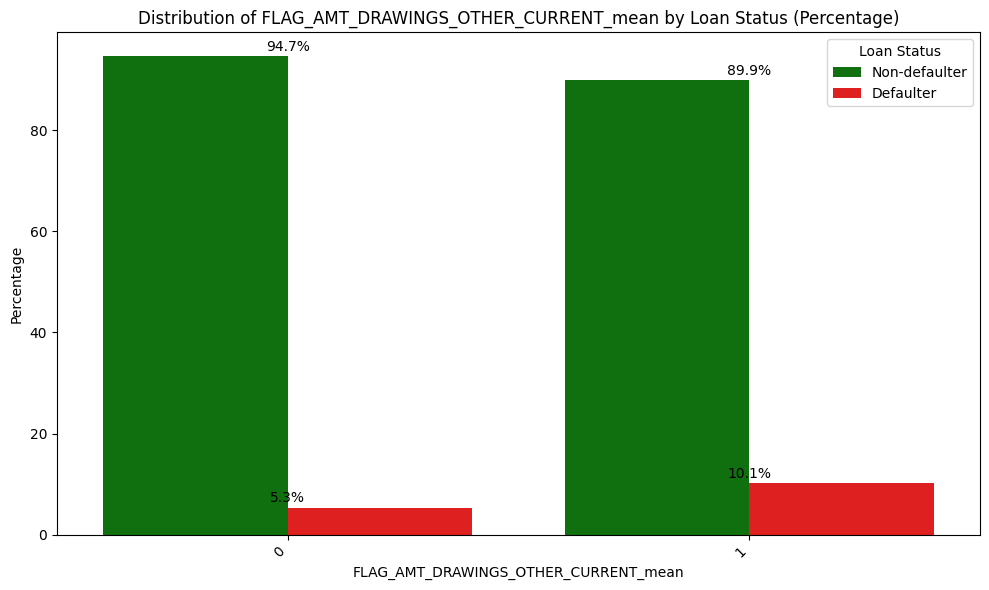

Chi-square Test for FLAG_AMT_DRAWINGS_OTHER_CURRENT_mean:
Chi2 statistic: 352.0499, p-value: 0.0000, Degrees of freedom: 1
There is a significant difference between defaulters and non-defaulters for this variable (FLAG_AMT_DRAWINGS_OTHER_CURRENT_mean).

Analyzing FLAG_AMT_DRAWINGS_ATM_CURRENT_mean:




FLAG_AMT_DRAWINGS_ATM_CURRENT_mean
1    41367
0    17323
Name: count, dtype: int64


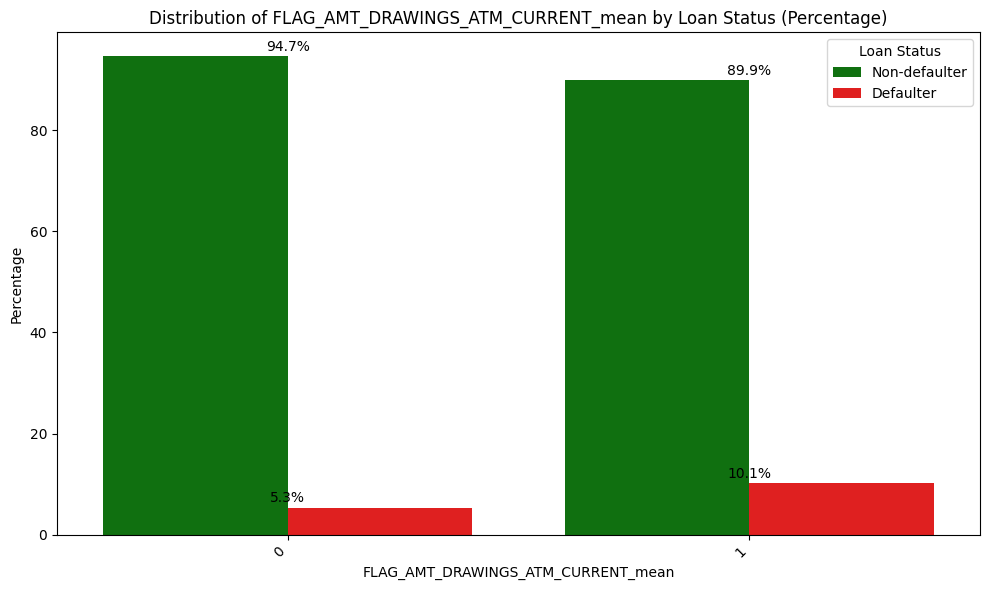

Chi-square Test for FLAG_AMT_DRAWINGS_ATM_CURRENT_mean:
Chi2 statistic: 352.0499, p-value: 0.0000, Degrees of freedom: 1
There is a significant difference between defaulters and non-defaulters for this variable (FLAG_AMT_DRAWINGS_ATM_CURRENT_mean).


In [25]:
# List of categorical columns
categorical_columns = ['NAME_CONTRACT_STATUS_<lambda>', 
                       'FLAG_AMT_PAYMENT_CURRENT_mean', 
                       'FLAG_AMT_DRAWINGS_POS_CURRENT_mean', 
                       'FLAG_AMT_DRAWINGS_OTHER_CURRENT_mean', 
                       'FLAG_AMT_DRAWINGS_ATM_CURRENT_mean']

# Apply the categorical analysis to each column


for column in categorical_columns:
    print(f"\nAnalyzing {column}:")
    categorical_analysis(merged_df, column, target='TARGET')


## Analysis of Credit Card Balance Feature Importance

---

The analysis reveals significant insights into applicants' financial behavior based on the most critical features from the `credit_card_balance` dataset. Below are the key findings:

- **`AMT_CREDIT_LIMIT_ACTUAL_mean`**:  
  The average credit limit across records is the most influential feature in assessing credit risk. Higher limits may imply trust from lenders, but excessive utilization within these limits could signal financial risk.

- **`SK_ID_PREV_count`**:  
  This count of previous credit applications reflects credit-seeking behavior. Applicants with numerous previous applications may exhibit higher risk, as frequent credit inquiries could indicate financial instability or a propensity to seek credit regularly.

- **`AMT_PAYMENT_CURRENT_sum` & `AMT_PAYMENT_CURRENT_mean`**:  
  High cumulative and average payments can indicate strong repayment capacity, a positive signal for creditworthiness. However, if these payments represent a large proportion of income, they could strain finances, especially if the applicant is reliant on credit.

- **`AMT_PAYMENT_TOTAL_CURRENT_sum` & `AMT_PAYMENT_TOTAL_CURRENT_mean`**:  
  These features reflect the sum and mean of all payments made. Consistent, high payments show repayment discipline, while inconsistencies or low payments might imply financial stress or potential risk of default.

- **`AMT_DRAWINGS_CURRENT_sum` & `AMT_DRAWINGS_CURRENT_mean`**:  
  Total and average amounts drawn from credit lines indicate credit utilization. High values could suggest a dependence on credit for regular expenses, raising red flags about potential overextension.

- **`AMT_INST_MIN_REGULARITY_mean`**:  
  The average minimum payment amount reveals whether applicants habitually make only minimum payments. Relying on minimum payments may suggest financial pressure, as they often indicate limited capacity to pay down debt quickly.

- **`AMT_DRAWINGS_ATM_CURRENT_mean`**:  
  ATM withdrawals from credit lines highlight applicants' cash needs. Frequent withdrawals from credit suggest liquidity issues, often signaling financial strain or emergency borrowing.

- **`AMT_BALANCE_mean`**:  
  The average balance reflects debt load. Higher balances, particularly those close to the credit limit, imply increased risk as they could indicate a heavier reliance on credit.

- **`CNT_DRAWINGS_CURRENT_sum`**:  
  This count of credit transactions shows the frequency of usage. High transaction counts indicate regular reliance on credit, a behavior often associated with increased financial risk.

- **`AMT_RECEIVABLE_mean` & `AMT_RECEIVABLE_sum`**:  
  These features reflect the amounts still due. Higher values suggest significant debt accumulation, possibly indicating difficulty in paying off balances and greater risk of default.

- **`AMT_RECEIVABLE_PRINCIPAL_mean`**:  
  The principal balance still owed highlights the remaining debt burden. A large balance here implies substantial remaining debt, often a key risk factor.

- **`CNT_INSTALMENT_MATURE_CUM_sum`**:  
  Cumulative matured installments give insight into whether applicants consistently meet payment deadlines. A high count of matured installments without timely payments suggests increased credit risk.

- **`SK_DPD_max` & `SK_DPD_DEF_max`**:  
  These features track the maximum number of days past due. High values indicate late payments, directly signaling credit risk and potential defaults.

---

### Conclusion

The analysis indicates that features related to **credit limit utilization**, **repayment habits**, **cash withdrawals**, and **balance consistency** are central to assessing applicants' financial behavior. Patterns show that applicants who frequently rely on credit for expenses, maintain high balances, or make minimum payments are more likely to be financially strained. Additionally, the consistent association between past due days and high default risk reinforces that repayment punctuality is crucial. These insights suggest that features capturing high credit usage, frequent cash withdrawals, and repayment irregularities can significantly improve credit risk assessments and contribute to more refined predictive models.


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Custom transformer for binary encoding
class CEncodeBinaryVariables(BaseEstimator, TransformerMixin):
    def __init__(self, binary_columns):
        self.binary_columns = binary_columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        label_encoder = LabelEncoder()
        
        for col in self.binary_columns:
            if col in X.columns:  # Check if column exists
                X[col] = label_encoder.fit_transform(X[col])
        
        return X


# Custom transformer for nominal encoding
class CEncodeNominalVariables(BaseEstimator, TransformerMixin):
    def __init__(self, nominal_columns, drop_first=True):
        self.nominal_columns = nominal_columns
        self.drop_first = drop_first
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # Only apply get_dummies if the columns are still in the DataFrame
        for col in self.nominal_columns:
            if col in X.columns:
                X = pd.get_dummies(X, columns=[col], drop_first=self.drop_first)
        
        return X


Cbinary_columns = ["FLAG_AMT_CURRENT_PAYMENT_mean", "FLAG_AMT_DRAWING_POS_mean", "FLAG_AMT_DRAWINGS_OTHER_CURRENT_mean", "FLAG_AMT_DRAWINGS_ATM_CURRENT_mean"]
Cnominal_columns = ["NAME_CONTRACT_STATUS_<lambda>"]
# Create the pipeline
encoding_pipeline_credit = Pipeline(steps=[
    ('binary_encoder', CEncodeBinaryVariables(binary_columns=Cbinary_columns)),
    ('nominal_encoder', CEncodeNominalVariables(nominal_columns=Cnominal_columns))
])

# Apply the pipeline (can run multiple times without issues)
final_df = encoding_pipeline_credit.fit_transform(merged_df)
final_df.head()


# Feature Selection and Aggregation Strategy

---

### 1. Goal: Reduce the Number of Columns

The primary goal of this step is to reduce the number of columns in our dataset. With so many features, many of which may have limited predictive power, simplifying the dataset will make the model more efficient and interpretable, and reduce the risk of overfitting.

### 2. Approach: Using a Random Forest Classifier for Feature Importance

To identify which features are most predictive of credit risk, I will use a **Random Forest classifier** to rank feature importance. Random Forest is ideal here because it can handle complex datasets, works well with mixed data types, and captures nonlinear relationships. This process will allow me to isolate the top 30 most informative features, which I’ll retain for more extensive feature engineering in the next steps. This selection will give a solid foundation to build upon, focusing on features that already show strong predictive potential.

### 3. Retaining Information from Low-Importance Features through Aggregation

For the remaining features with lower importance scores, I won’t discard them entirely. Instead, I will **aggregate these low-importance features** to capture any underlying patterns without keeping each feature individually. By summing, averaging, or creating indices from similar features (e.g., flags or stability indicators), I’ll retain their informational value while simplifying the dataset. This nuanced approach allows me to maintain valuable data signals, even if individual features aren’t highly predictive, supporting the model's overall robustness.

---

This strategy enables a balanced approach to feature selection, where I prioritize high-impact features for further feature engineering while still retaining value from less-informative features through aggregation. This setup provides a focused and manageable dataset that is well-prepared for deeper analysis and engineering.


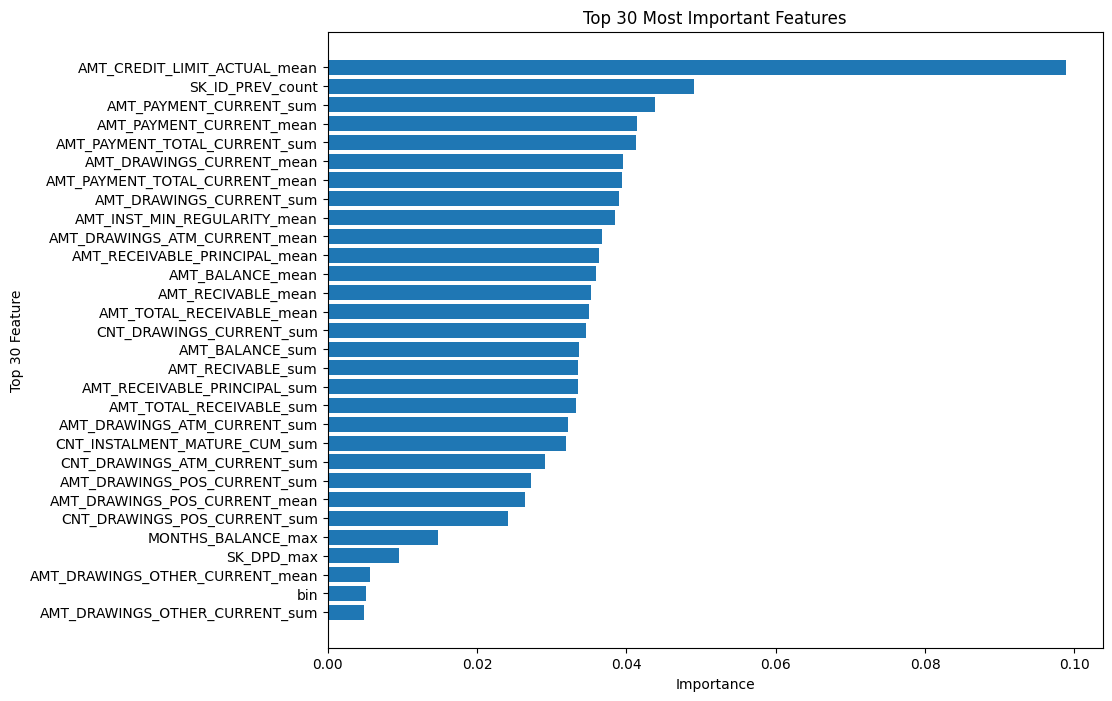

In [37]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
# Set SK_ID_CURR as the index, drop the TARGET column, and assign to X
X = final_df.set_index('SK_ID_CURR').drop(columns=['TARGET'])
y = final_df['TARGET']


# Convert all categorical columns to numeric using Label Encoding or One-Hot Encoding as needed
X_encoded = X.copy()  # Create a copy to avoid modifying the original X
for col in X_encoded.select_dtypes(include=['object', 'category']).columns:
    if X_encoded[col].nunique() <= 10:  # Use Label Encoding for low cardinality
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col])
    else:
        X_encoded = pd.get_dummies(X_encoded, columns=[col], drop_first=True)

# Train the model with encoded features
model = RandomForestClassifier(random_state=42, n_jobs=-1)
model.fit(X_encoded, y)

# Get feature importances and create a DataFrame
feature_importances = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

# Split into top 30 features and the rest
top_30_features = feature_importances.head(30)

# Plot Top 30 Features
plt.figure(figsize=(10, 8))
plt.barh(top_30_features['feature'], top_30_features['importance'], align='center')
plt.xlabel('Importance')
plt.ylabel('Top 30 Feature')
plt.title('Top 30 Most Important Features')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()




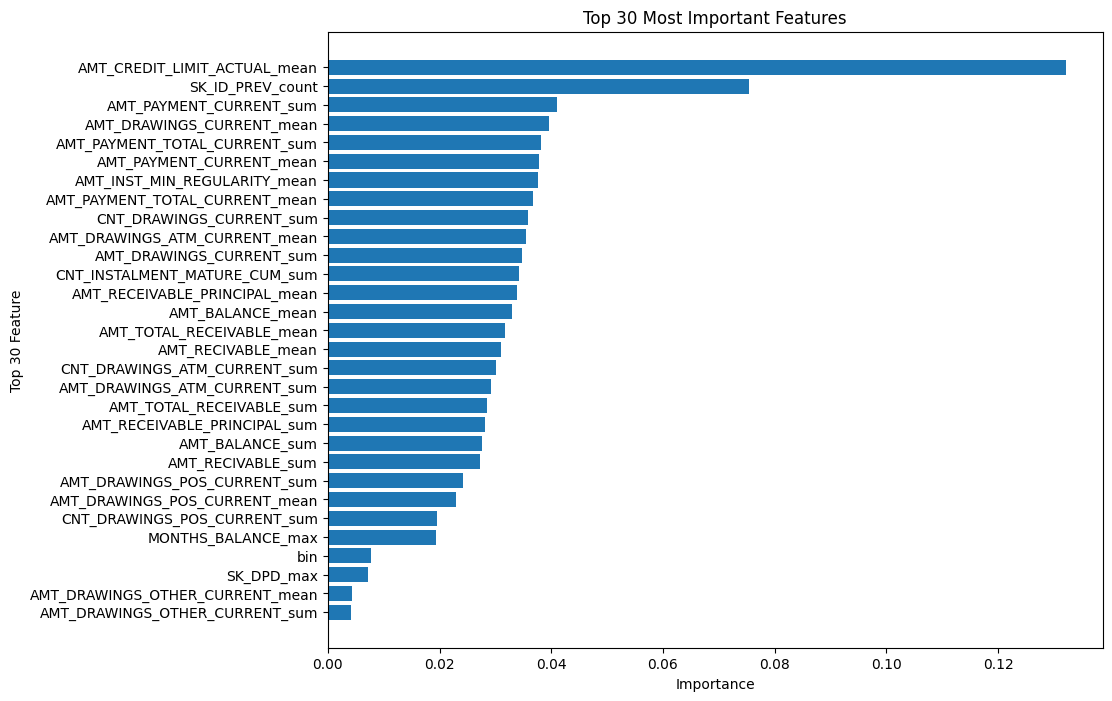

Features with VIF greater than 5 (if any):
                          feature            VIF
3       AMT_TOTAL_RECEIVABLE_mean  484383.998794
4                AMT_BALANCE_mean   33920.871693
6                SK_ID_PREV_count      26.669922
7    AMT_INST_MIN_REGULARITY_mean      60.388990
8   CNT_INSTALMENT_MATURE_CUM_sum       7.492369
9   AMT_RECEIVABLE_PRINCIPAL_mean    7735.744696
10             AMT_RECIVABLE_mean  688277.546217
11   AMT_RECEIVABLE_PRINCIPAL_sum   14841.077189
12              AMT_RECIVABLE_sum   14895.040585
14                            bin      21.056796
Reduced set of features after handling multicollinearity:
['AMT_PAYMENT_CURRENT_mean', 'AMT_DRAWINGS_OTHER_CURRENT_sum', 'CNT_DRAWINGS_ATM_CURRENT_sum', 'AMT_TOTAL_RECEIVABLE_mean', 'AMT_BALANCE_mean', 'AMT_CREDIT_LIMIT_ACTUAL_mean', 'SK_ID_PREV_count', 'AMT_INST_MIN_REGULARITY_mean', 'CNT_INSTALMENT_MATURE_CUM_sum', 'AMT_RECEIVABLE_PRINCIPAL_mean', 'AMT_RECIVABLE_mean', 'AMT_RECEIVABLE_PRINCIPAL_sum', 'AMT_RECIVAB

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

# Identify non-numeric columns
non_numeric_cols = X.select_dtypes(include=['object', 'category']).columns

# Convert non-numeric columns
for col in non_numeric_cols:
    if X[col].nunique() <= 10:  # Label Encoding for low-cardinality categorical features
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
    else:  # One-hot encoding for higher-cardinality features
        X = pd.get_dummies(X, columns=[col], drop_first=True)

# Train the Random Forest Classifier on transformed data
model = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')
model.fit(X, y)

# Get feature importances and create a DataFrame
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)


# Select the top 30 features
top_30_features = feature_importances.head(30)
top_30_feature_names = top_30_features['feature'].tolist()
X_top_30 = X[top_30_feature_names]

# Plot Top 30 Features
plt.figure(figsize=(10, 8))
plt.barh(top_30_features['feature'], top_30_features['importance'], align='center')
plt.xlabel('Importance')
plt.ylabel('Top 30 Feature')
plt.title('Top 30 Most Important Features')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

# Step: Group features based on aggregation types
groups = {
    'AMT_PAYMENT': [col for col in X_top_30.columns if col.startswith('AMT_PAYMENT')],
    'AMT_DRAWINGS': [col for col in X_top_30.columns if col.startswith('AMT_DRAWINGS')],
    'CNT_DRAWINGS': [col for col in X_top_30.columns if col.startswith('CNT_DRAWINGS')],
    'AMT_TOTAL_RECEIVABLE': [col for col in X_top_30.columns if col.startswith('AMT_TOTAL_RECEIVABLE')],
    'AMT_BALANCE': [col for col in X_top_30.columns if col.startswith('AMT_BALANCE')],
    # Add more groups as necessary based on your feature names
}

# Initialize list to hold selected representative features
selected_features = []

# For each group, select a representative feature with the least collinearity
for group_name, features in groups.items():
    # Extract the sub-correlation matrix for the group
    sub_corr_matrix = X_top_30[features].corr().abs()
    
    # Calculate the average correlation of each feature within its group
    avg_corr = sub_corr_matrix.mean().sort_values()
    
    # Select the feature with the lowest average correlation as the representative feature
    representative_feature = avg_corr.idxmin()
    selected_features.append(representative_feature)

# Add any remaining top 30 features not part of the defined groups
ungrouped_features = [f for f in top_30_feature_names if f not in sum(groups.values(), [])]
selected_features.extend(ungrouped_features)

# Final Reduced DataFrame based on selected features
X_reduced = X[selected_features]

# Calculate VIF to ensure no high multicollinearity remains in reduced set
vif_data = pd.DataFrame()
vif_data["feature"] = X_reduced.columns
vif_data["VIF"] = [variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])]

# Display features with high VIF
print("Features with VIF greater than 5 (if any):")
print(vif_data[vif_data["VIF"] > 5])

# Display the reduced set of selected features
print("Reduced set of features after handling multicollinearity:")
print(selected_features)


In [39]:
# Display the remaining features as a ranked list by importance
# Get feature importances and create a DataFrame


remaining_features = feature_importances.iloc[30:]  # This line restores remaining_features

# Display the remaining features ranked by importance
print("Remaining Features Ranked by Importance")
display(remaining_features)


Remaining Features Ranked by Importance


,feature,importance
30,SK_DPD_DEF_max,0.003718
26,CNT_DRAWINGS_OTHER_CURRENT_sum,0.002572
36,NAME_CONTRACT_STATUS_<lambda>_Completed,0.001686
33,FLAG_AMT_DRAWINGS_OTHER_CURRENT_mean,0.000757
38,NAME_CONTRACT_STATUS_<lambda>_Signed,0.000555
32,FLAG_AMT_DRAWINGS_POS_CURRENT_mean,0.000544
34,FLAG_AMT_DRAWINGS_ATM_CURRENT_mean,0.000521
31,FLAG_AMT_PAYMENT_CURRENT_mean,0.000359
37,NAME_CONTRACT_STATUS_<lambda>_Demand,0.000005


In [40]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# Define the reduced feature set after VIF filtering
Cselected_features = [
    'SK_ID_CURR', 'TARGET', 'AMT_PAYMENT_CURRENT_mean', 'AMT_DRAWINGS_OTHER_CURRENT_sum', 
    'CNT_DRAWINGS_ATM_CURRENT_sum', 'AMT_TOTAL_RECEIVABLE_mean', 
    'AMT_BALANCE_mean', 'AMT_CREDIT_LIMIT_ACTUAL_mean', 'SK_ID_PREV_count', 
    'AMT_INST_MIN_REGULARITY_mean', 'AMT_RECIVABLE_mean', 
    'AMT_RECEIVABLE_PRINCIPAL_mean', 'AMT_RECIVABLE_sum', 
    'AMT_RECEIVABLE_PRINCIPAL_sum', 'CNT_INSTALMENT_MATURE_CUM_sum', 
    'MONTHS_BALANCE_max', 'SK_DPD_max', 'SK_DPD_DEF_max'
]

# Define the `Payment_Behavior_Index` columns
Cpayment_behavior_flags = [
    'FLAG_AMT_PAYMENT_CURRENT_mean', 
    'FLAG_AMT_DRAWINGS_POS_CURRENT_mean', 
    'FLAG_AMT_DRAWINGS_OTHER_CURRENT_mean', 
    'FLAG_AMT_DRAWINGS_ATM_CURRENT_mean'
]

# Custom transformer for selecting features
class CFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.features]

# Custom transformer to create `Payment_Behavior_Index`
class CPaymentBehaviorAggregator(BaseEstimator, TransformerMixin):
    def __init__(self, flags):
        self.flags = flags
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Create `Payment_Behavior_Index` as the mean of the specified flag columns
        X = X.copy()
        X['Payment_Behavior_Index'] = X[self.flags].mean(axis=1)
        # Return only the `Payment_Behavior_Index`
        return X[['Payment_Behavior_Index']]

# Create the pipeline
credit_pipeline = Pipeline([
    ('feature_selector', CFeatureSelector(features=selected_features)),
    ('payment_behavior_aggregator', CPaymentBehaviorAggregator(flags=Cpayment_behavior_flags))
])

# Apply the pipeline to the credit dataset
reduced_data = pd.concat([
    credit_pipeline.named_steps['feature_selector'].transform(final_df),
    credit_pipeline.named_steps['payment_behavior_aggregator'].transform(final_df)
], axis=1)

# Display the final DataFrame with selected features and the Payment Behavior Index
print("Final reduced features and Payment Behavior Index:")

reduced_data.head()


Final reduced features and Payment Behavior Index:


,AMT_PAYMENT_CURRENT_mean,AMT_DRAWINGS_OTHER_CURRENT_sum,CNT_DRAWINGS_ATM_CURRENT_sum,AMT_TOTAL_RECEIVABLE_mean,AMT_BALANCE_mean,AMT_CREDIT_LIMIT_ACTUAL_mean,SK_ID_PREV_count,AMT_INST_MIN_REGULARITY_mean,CNT_INSTALMENT_MATURE_CUM_sum,AMT_RECEIVABLE_PRINCIPAL_mean,AMT_RECIVABLE_mean,AMT_RECEIVABLE_PRINCIPAL_sum,AMT_RECIVABLE_sum,MONTHS_BALANCE_max,bin,SK_DPD_max,Payment_Behavior_Index
0,9856.811065,0.0,0.0,0.000000,0.000000,765000.0,11,0.000000,0.0,0.000000,0.000000,0.00,0.000,-2,25-50%,0,0.0
1,47511.357750,0.0,2.0,325823.123864,326387.033182,540000.0,22,17247.003158,171.0,315057.608182,325823.123864,6931267.38,7168108.725,-2,25-50%,0,1.0
2,1521.056368,0.0,1.0,15440.779421,15444.775895,67500.0,95,1138.917316,2920.0,14876.029895,15440.779421,1413222.84,1466874.045,-2,75-100%,0,1.0
3,9856.811065,0.0,0.0,0.000000,0.000000,45000.0,22,0.000000,0.0,0.000000,0.000000,0.00,0.000,-1,25-50%,0,0.0
4,17700.000000,0.0,11.0,189464.668548,189942.104032,225000.0,31,9352.813500,465.0,181261.707097,189464.668548,5619112.92,5873404.725,-1,50-75%,0,1.0
